In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t
import scipy.stats as stats
import pylab

In [15]:
# Load the data from the CSV file
sales_data = pd.read_csv('sales_data.csv')
sales_data.head(10)

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear,datetime
0,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06,2011-05-31
1,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06,2011-05-31
2,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06,2011-05-31
3,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06,2011-05-31
4,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-05-31
5,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-01
6,1,3578.2700,3578.2700,3953.9884,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
7,1,3374.9900,3374.9900,3729.3640,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
8,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06,2011-06-01
9,1,3578.2700,3578.2700,3953.9884,Bikes,United States,1.051085e+07,5.366576e+06,2011-06-02


In [16]:
# Convert 'datetime' column to datetime type
sales_data['datetime'] = pd.to_datetime(sales_data['datetime'])

# Set 'datetime' as the index
sales_data.set_index('datetime', inplace=True)
sales_data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.2700,3578.2700,3953.9884,Bikes,Canada,6.771829e+06,5.693989e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,France,4.772398e+06,2.396540e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,United States,7.887187e+06,3.298694e+06
2011-05-31,1,699.0982,699.0982,772.5036,Bikes,United States,1.051085e+07,5.366576e+06
2011-05-31,1,3399.9900,3399.9900,3756.9890,Bikes,Australia,5.977815e+06,2.278549e+06


In [17]:
countries = sales_data['Country'].unique()
countries = list(countries)

In [18]:
sales_data_country = {country: sales_data[sales_data['Country'] == country] for country in countries}


sales_data_country[countries[0]]
    

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,Country,SalesYTD,SalesLastYear
datetime,,,,,,,,
2011-05-31,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-18,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-23,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-24,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
2011-06-29,1,3578.27,3578.27,3953.9884,Bikes,Canada,6.771829e+06,5693988.86
...,...,...,...,...,...,...,...,...
2014-06-30,1,21.98,21.98,34.2219,Accessories,Canada,6.771829e+06,5693988.86
2014-06-30,1,8.99,8.99,34.2219,Clothing,Canada,6.771829e+06,5693988.86
2014-06-30,1,21.98,21.98,209.9169,Accessories,Canada,6.771829e+06,5693988.86


In [19]:
def train_test_split_country(sales_data_country):
    combine_train_test = {
        country: data['LineTotal'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[-6:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [20]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

# Example: Access the resampled data for the first country
first_country = countries[0]
print(f"Monthly sales for country '{first_country}':")
print(train_data[first_country]) 

Monthly sales for country 'Canada':
datetime
2011-05-31     95655.0397
2011-06-30     18387.1682
2011-07-31    227046.2522
2011-08-31    230723.1560
2011-09-30     11929.7264
2011-10-31    408931.9592
2011-11-30     36278.5182
2011-12-31    193883.2114
2012-01-31    540411.1094
2012-02-29    195665.0395
2012-03-31    341175.2329
2012-04-30    187343.0273
2012-05-31    410703.2592
2012-06-30    606395.3965
2012-07-31    516949.3122
2012-08-31    360226.8378
2012-09-30    473956.7038
2012-10-31    391016.7894
2012-11-30    255946.8916
2012-12-31    299106.5787
2013-01-31    312671.7199
2013-02-28    335734.3084
2013-03-31    406216.6670
2013-04-30    384170.9064
2013-05-31    326392.0564
2013-06-30    458265.4213
2013-07-31    520962.4820
2013-08-31    289444.1088
2013-09-30    428973.0347
2013-10-31    566337.5012
2013-11-30    305425.6094
2013-12-31    386650.3960
Freq: ME, Name: LineTotal, dtype: float64


In [21]:
print(test_data[first_country]) 

datetime
2014-01-31    445319.3277
2014-02-28     77497.2600
2014-03-31    688402.5747
2014-04-30    136178.3100
2014-05-31    568146.7268
2014-06-30     10381.5500
Freq: ME, Name: LineTotal, dtype: float64


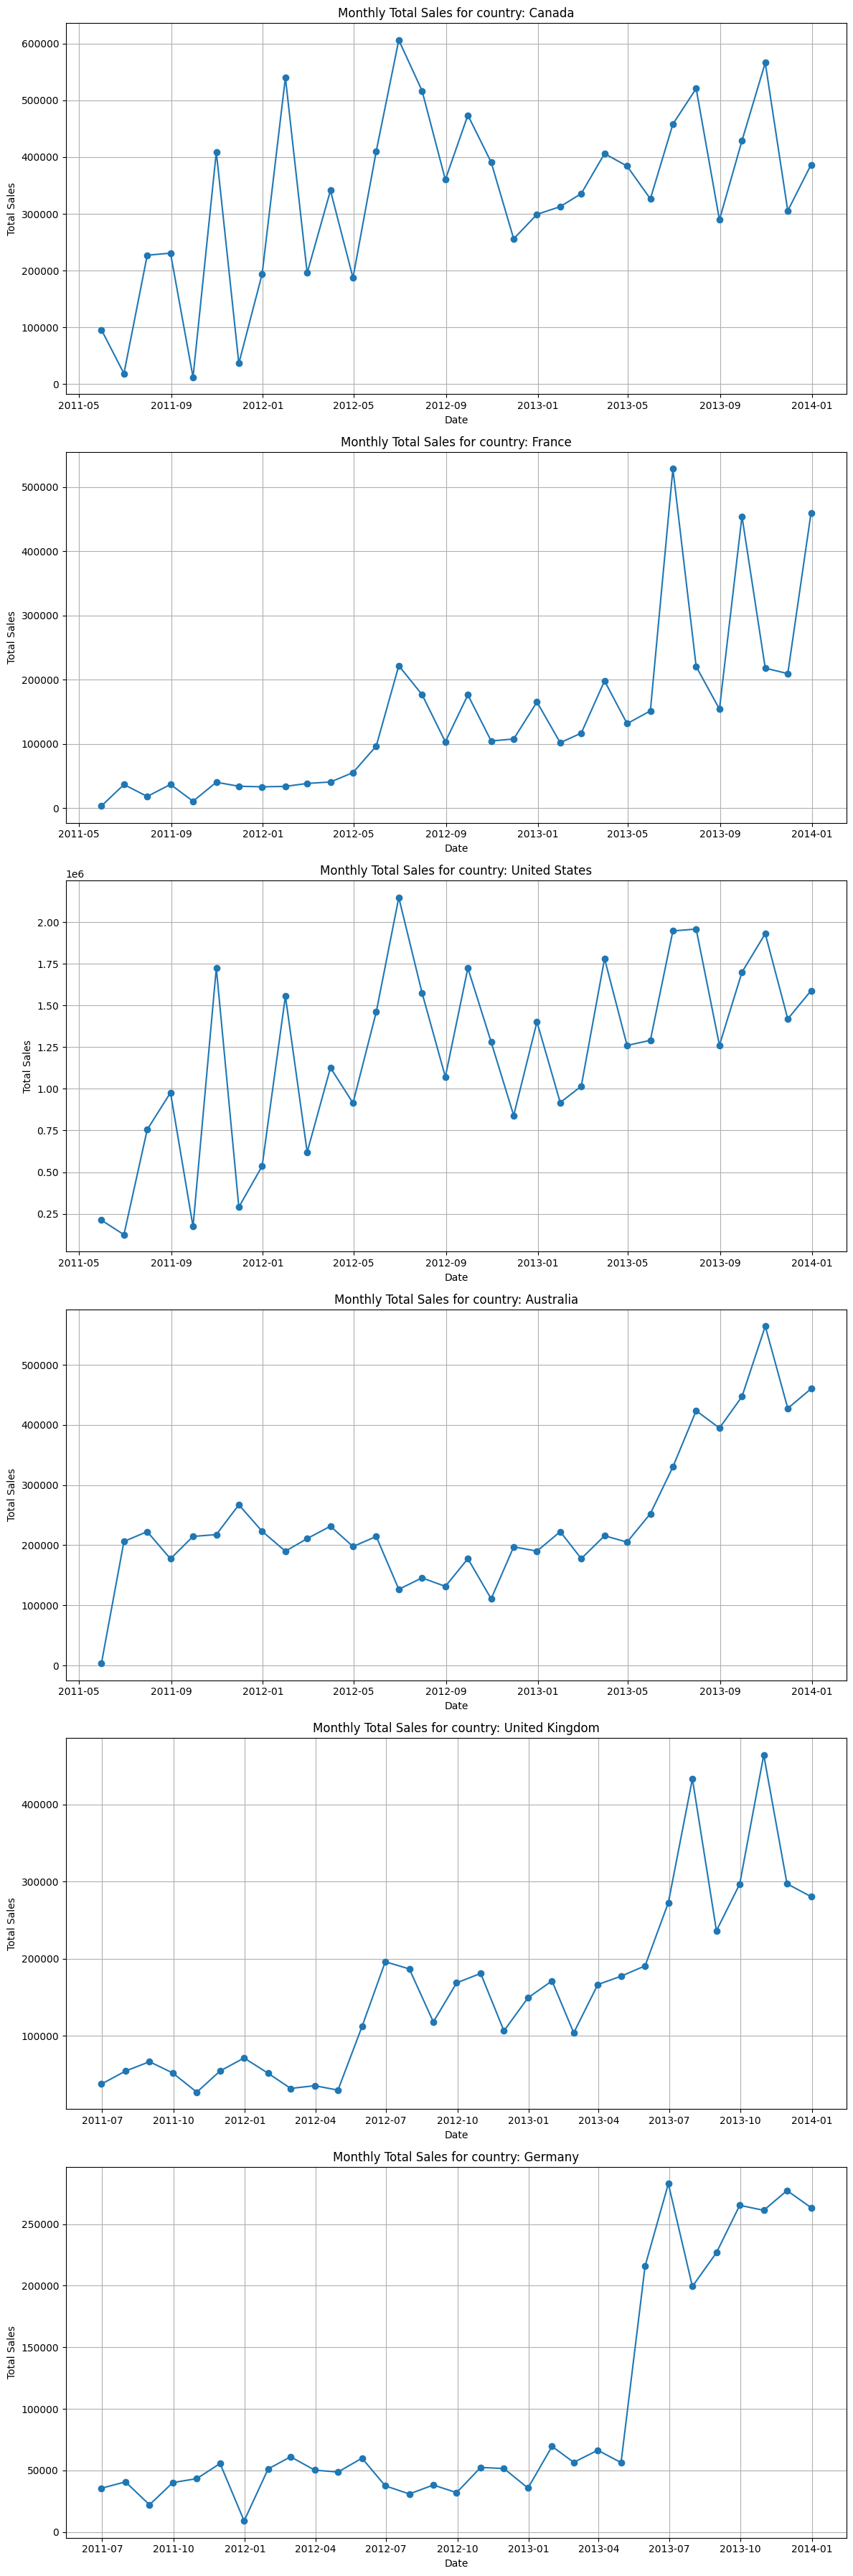

In [22]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [23]:
def adf_test(series):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))


# Perform ADF test
for (country, data) in train_data.items():
    print(f'{country}')
    adf_test(data)

Canada
ADF Statistic: -4.308696337666193
p-value: 0.0004290587244301073
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
France
ADF Statistic: 0.384949158779835
p-value: 0.9809232855183833
Critical Value (1%): -3.788
Critical Value (5%): -3.013
Critical Value (10%): -2.646
United States
ADF Statistic: -4.244483089848515
p-value: 0.0005535192577610068
Critical Value (1%): -3.661
Critical Value (5%): -2.961
Critical Value (10%): -2.619
Australia
ADF Statistic: -0.34940651759328095
p-value: 0.9182095599657245
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621
United Kingdom
ADF Statistic: 0.7284207423297886
p-value: 0.9903883181461013
Critical Value (1%): -3.770
Critical Value (5%): -3.005
Critical Value (10%): -2.643
Germany
ADF Statistic: -0.56003461255007
p-value: 0.8797593037512332
Critical Value (1%): -3.670
Critical Value (5%): -2.964
Critical Value (10%): -2.621


In [24]:
#return p value
def calculate_p_value(data):
    """
    If p-value > 0.05: The time series is non-stationary.
    If p-value ≤ 0.05: The time series is stationary.
    """
    result = adfuller(data)
    return result[1]



#Make the time series stationary
def make_stationary(combined_data, train_data, test_data):
    """
    Make train_data stationary and apply the same differencing logic to test_data,
    ensuring consistent transformation without combining datasets.
    """
    differencing_info = {}  # Store number of differences for each country
    stationary_combined_data = {}
    stationary_train_data = {}
    stationary_test_data = {}

    for country, train_series in train_data.items():
        print(f"\nProcessing country: {country}")
        
        # Initialize differencing count and check train_data for stationarity
        differences = 0
        p_value = calculate_p_value(train_series)
        current_train_series = train_series

        # Apply differencing to train_data until stationary
        while p_value > 0.05:
            current_train_series = current_train_series.diff().dropna()
            differences += 1
            p_value = calculate_p_value(current_train_series)
        
        # Store stationary train data
        stationary_train_data[country] = current_train_series
        differencing_info[country] = differences

        # Apply the same differencing logic to combined_data and test_data
        current_test_series = combined_data[country]
        for _ in range(differences):
            # Use the last value of train_series for differencing
            current_test_series = current_test_series.diff().dropna()
            
        # Store stationary combined data
        stationary_combined_data[country] = current_test_series
        
        
        current_test_series = test_data[country]
        for _ in range(differences):
            # Use the last value of train_series for differencing
            current_test_series = current_test_series.diff().dropna()
        
        # Store stationary test data
        stationary_test_data[country] = current_test_series

        print(f"Country: {country} - Stationary after {differences} differences.")


# Apply the function to train_data and test_data
make_stationary(combined_data, train_data, test_data)


Processing country: Canada
Country: Canada - Stationary after 0 differences.

Processing country: France
Country: France - Stationary after 1 differences.

Processing country: United States
Country: United States - Stationary after 0 differences.

Processing country: Australia
Country: Australia - Stationary after 1 differences.

Processing country: United Kingdom
Country: United Kingdom - Stationary after 2 differences.

Processing country: Germany
Country: Germany - Stationary after 1 differences.


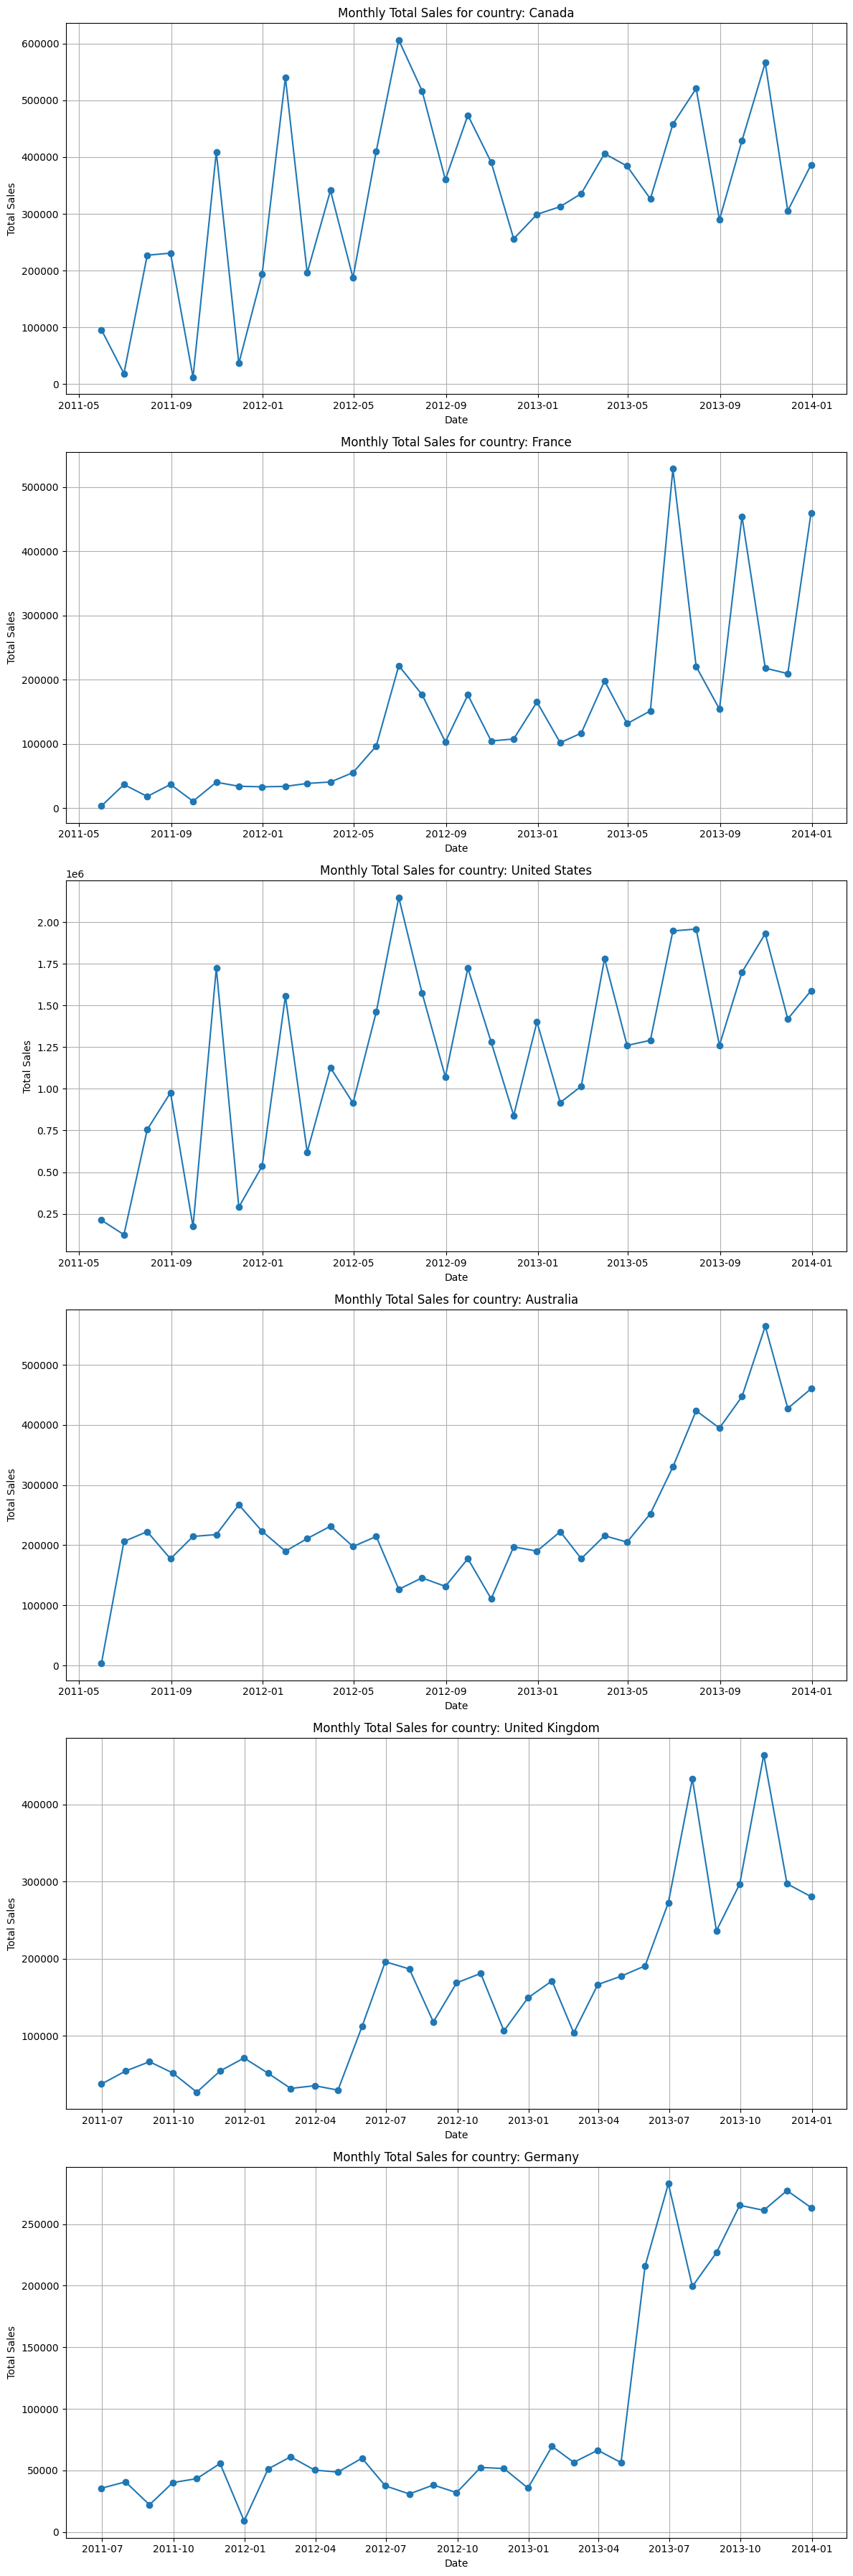

In [25]:
n_countries = len(countries)  # Total number of countries

plt.figure(figsize=(12, 6 * n_countries))  # Adjust figure size dynamically based on the number of countries

for i, (country, monthly_sales) in enumerate(train_data.items(), 1):
    plt.subplot(n_countries, 1, i)
    plt.plot(monthly_sales, marker='o', linestyle='-')
    plt.title(f"Monthly Total Sales for country: {country}")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## ARIMA

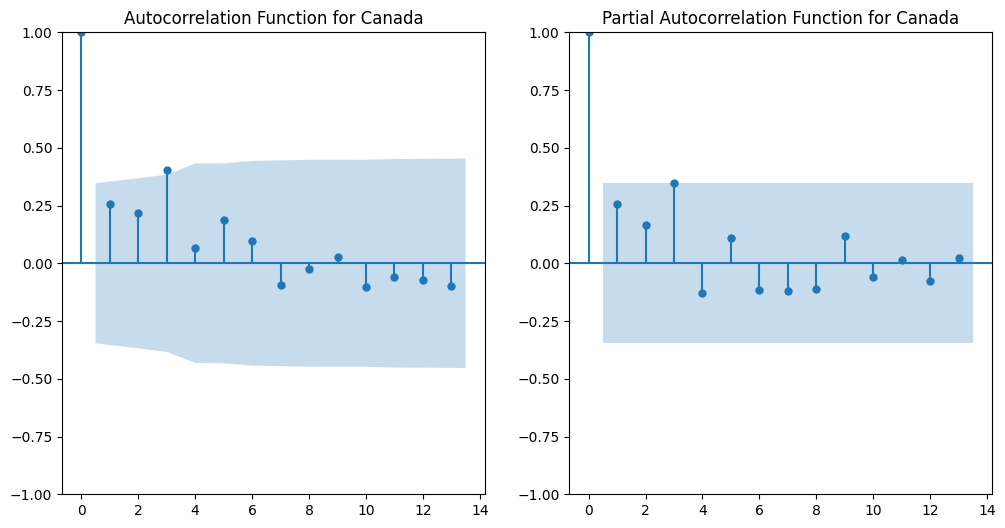

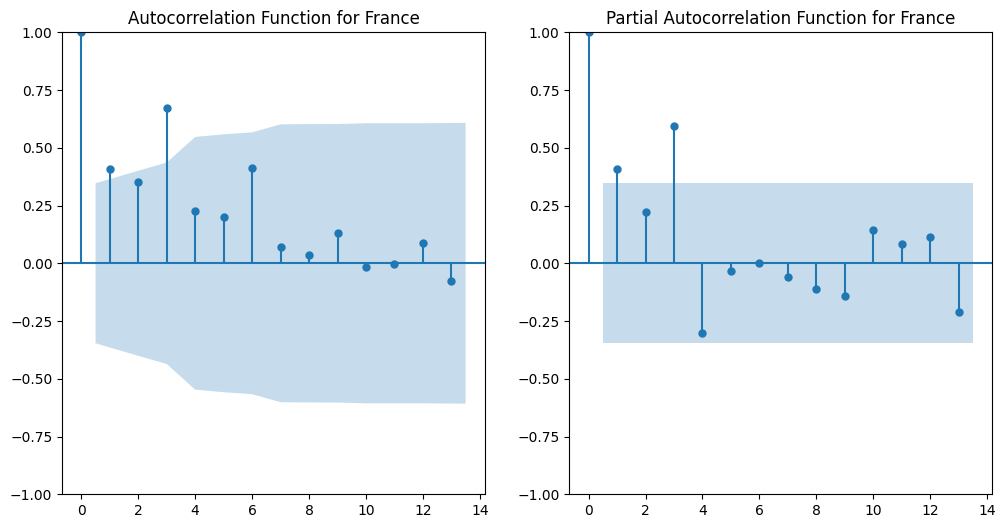

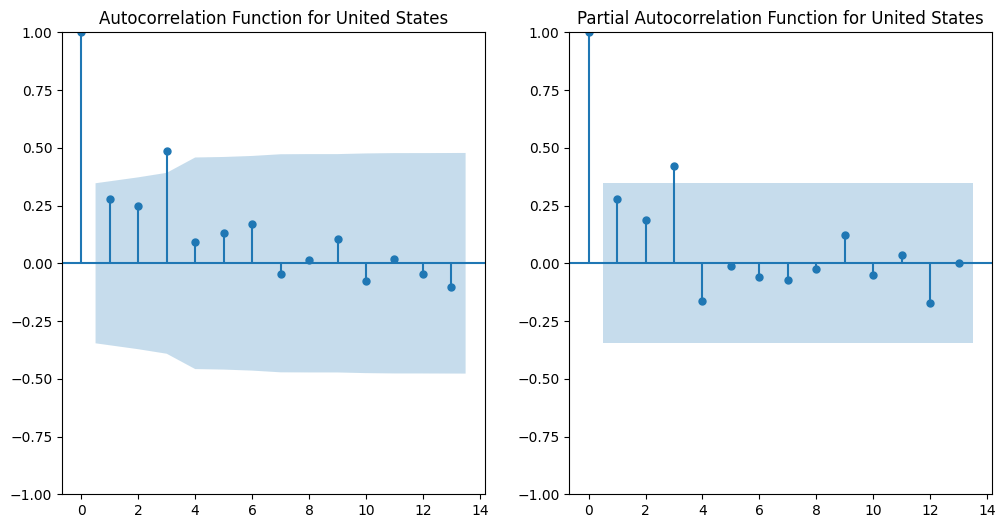

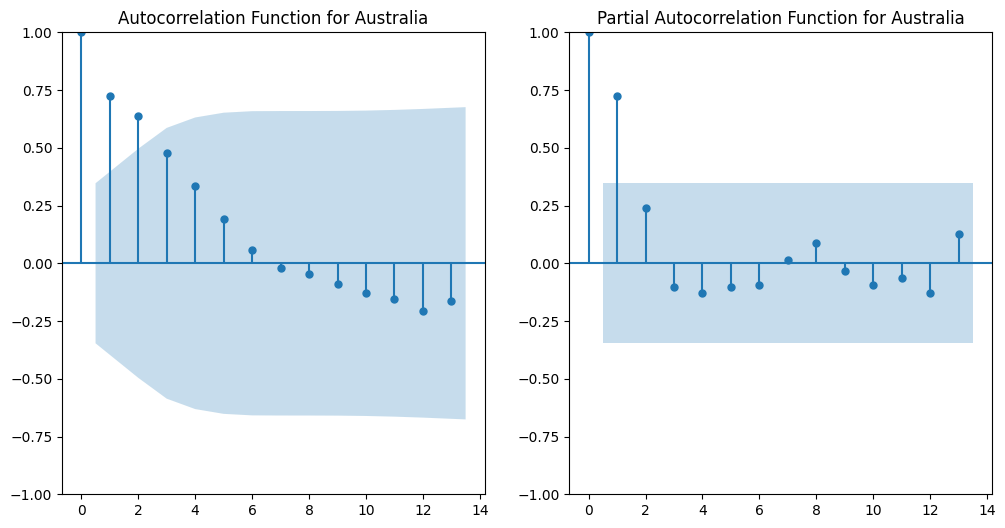

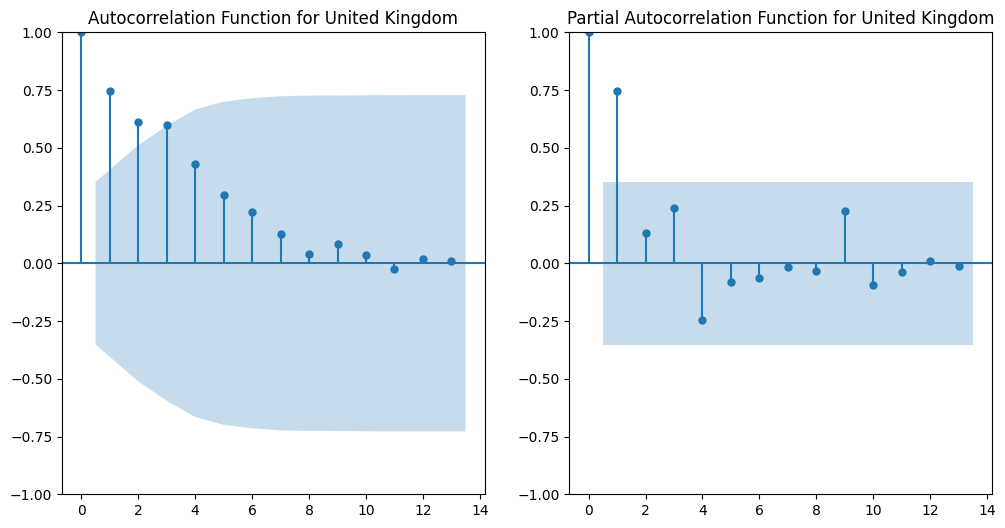

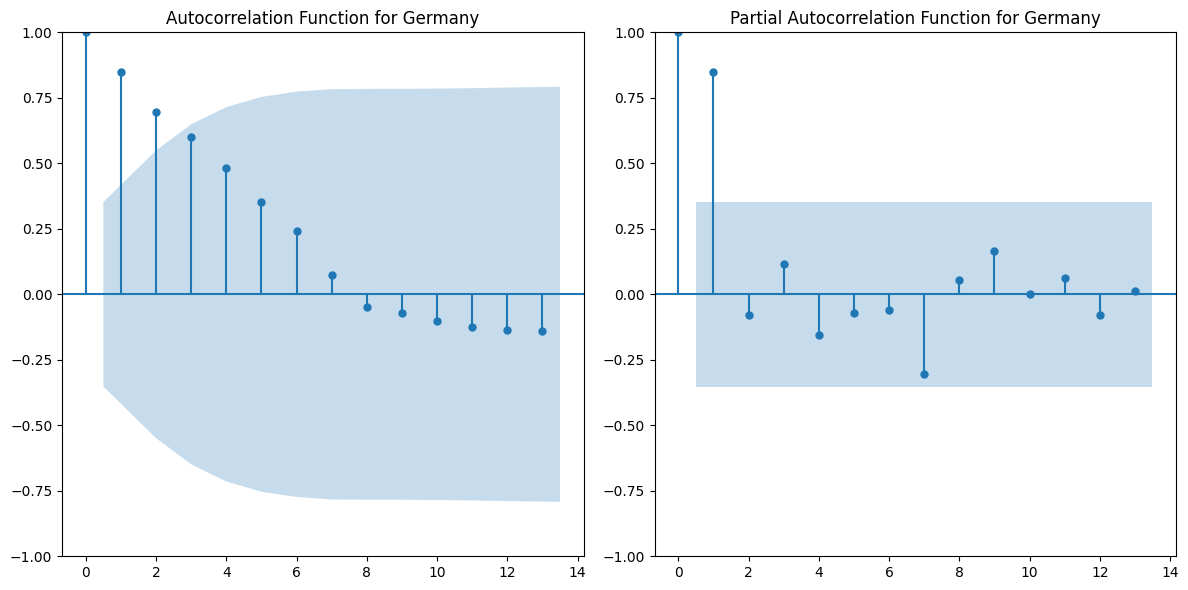

In [26]:
# Define maximum lags (adjust as necessary)
max_lags = 13

# Loop through each country and plot ACF and PACF
for country, monthly_sales in train_data.items():
    plt.figure(figsize=(12, 6))
    
    # Plot ACF
    plt.subplot(121)
    plot_acf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Autocorrelation Function for {country}')
    
    # Plot PACF
    plt.subplot(122)
    plot_pacf(monthly_sales, ax=plt.gca(), lags=max_lags)
    plt.title(f'Partial Autocorrelation Function for {country}')
    
plt.tight_layout()
plt.show()

In [27]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=False, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.701, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=843.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=835.881, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=831.911, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=841.922, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.257, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=830.640, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=831.905, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=830.777, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=831.204, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=832.809, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=828.903, Time=0.03 sec

Best model:  AR

In [28]:
countries

['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany']

In [29]:
model_countries = {}

model_countries[countries[0]] = ARIMA(train_data[countries[0]], order=(3, 0, 3))
model_countries[countries[1]] = ARIMA(train_data[countries[1]], order=(3, 1, 3))
model_countries[countries[2]] = ARIMA(train_data[countries[2]], order=(3, 0, 3))
model_countries[countries[3]] = ARIMA(train_data[countries[3]], order=(1, 1, 2))
model_countries[countries[4]] = ARIMA(train_data[countries[4]], order=(1, 2, 3))
model_countries[countries[5]] = ARIMA(train_data[countries[5]], order=(1, 1, 2))

In [30]:
model_fit_countries = {}

for (country, model) in model_countries.items():
    print(country)
    model_fit_countries[country] = model_countries[country].fit()

Canada


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


France
United States
Australia
United Kingdom
Germany


c:\Users\Hi There\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
model_fit_countries.items()

dict_items([('Canada', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE3287620>), ('France', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE296DEE0>), ('United States', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE296E120>), ('Australia', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE2ABA870>), ('United Kingdom', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE2AB8AA0>), ('Germany', <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x000001FAE31B4050>)])

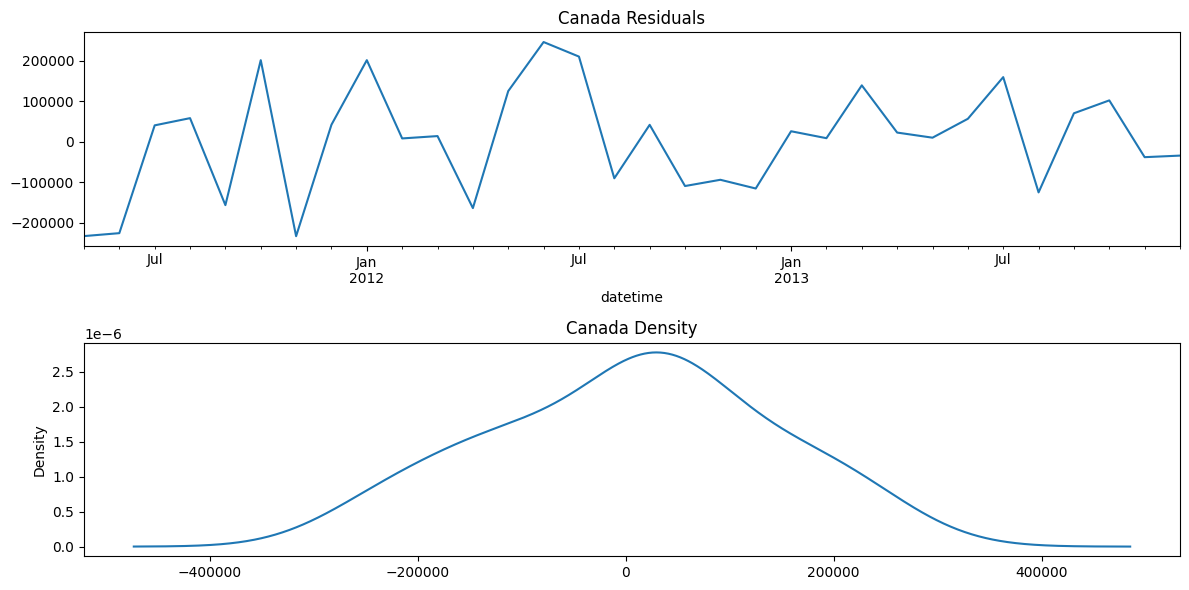

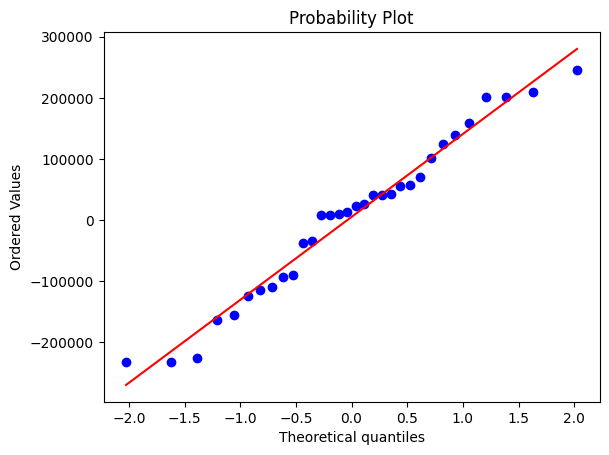

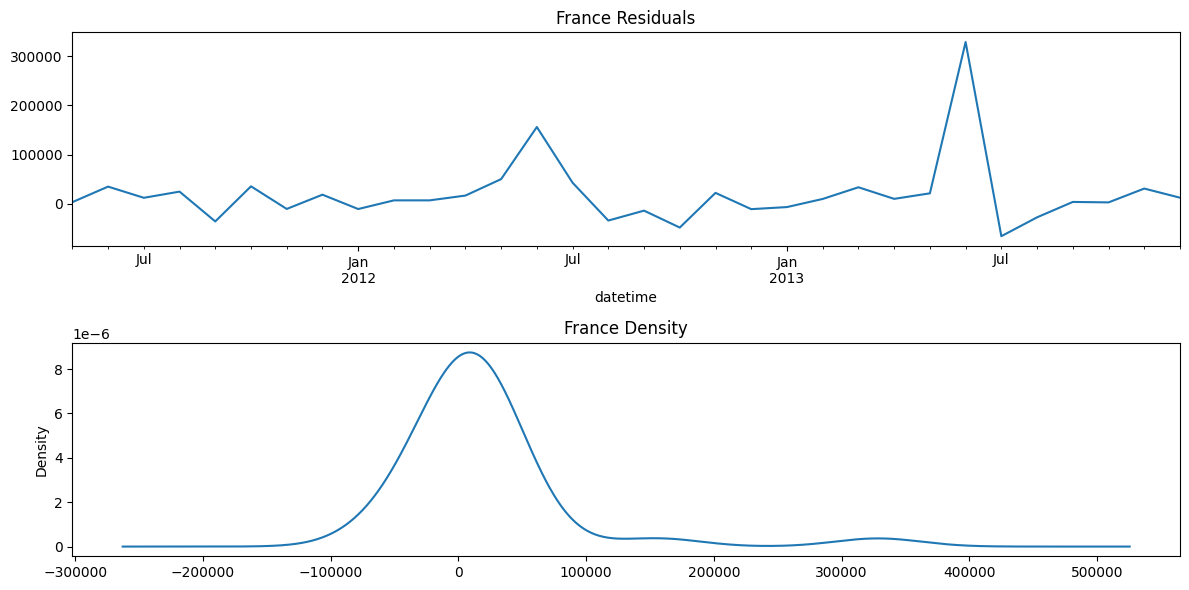

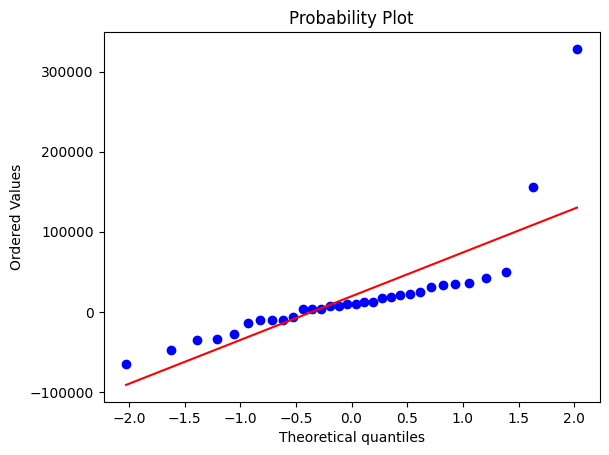

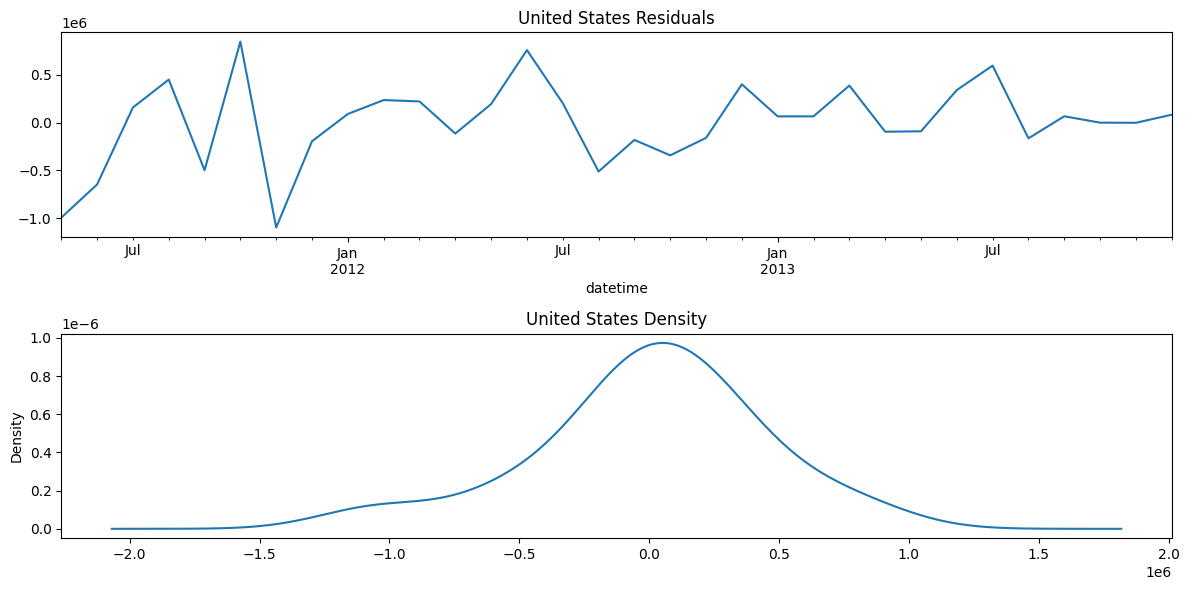

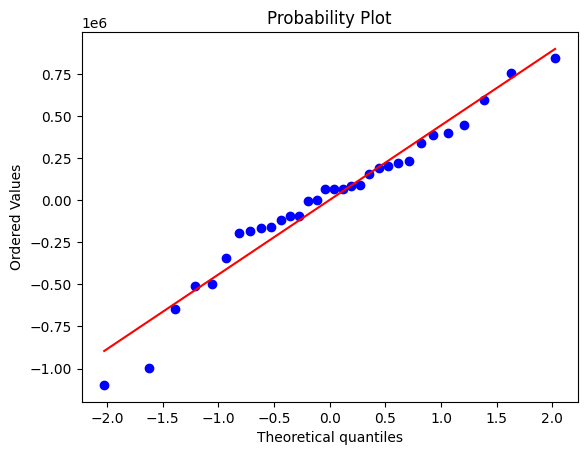

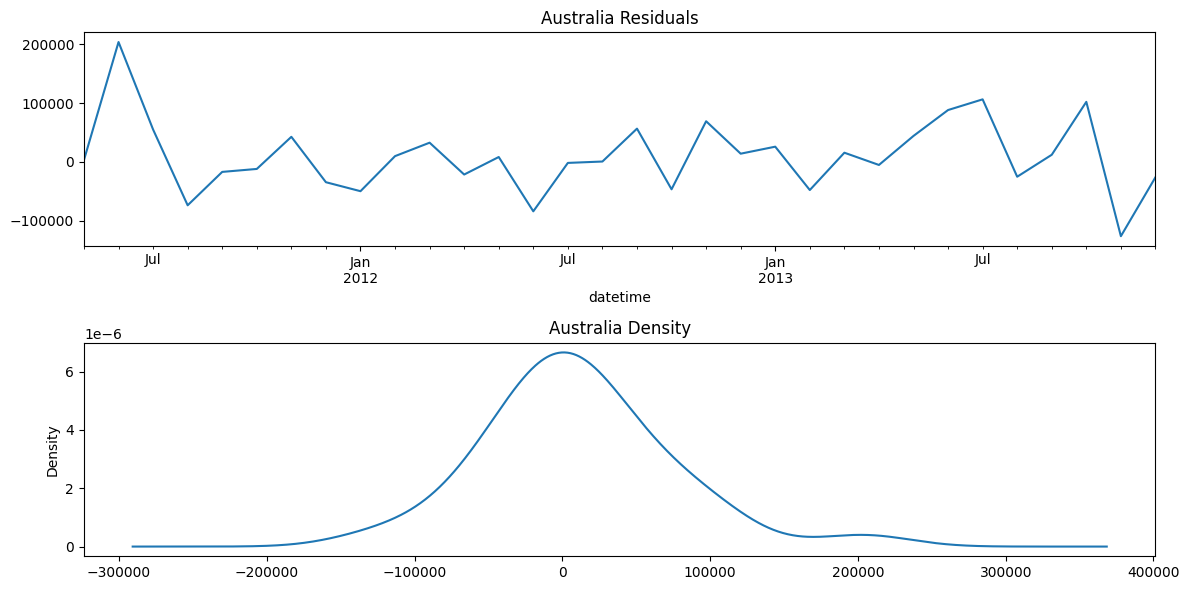

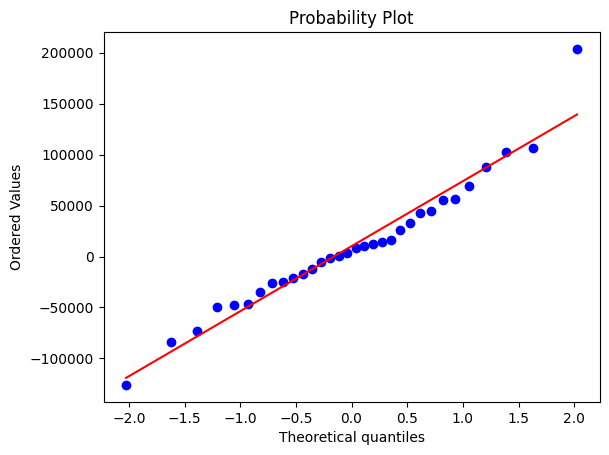

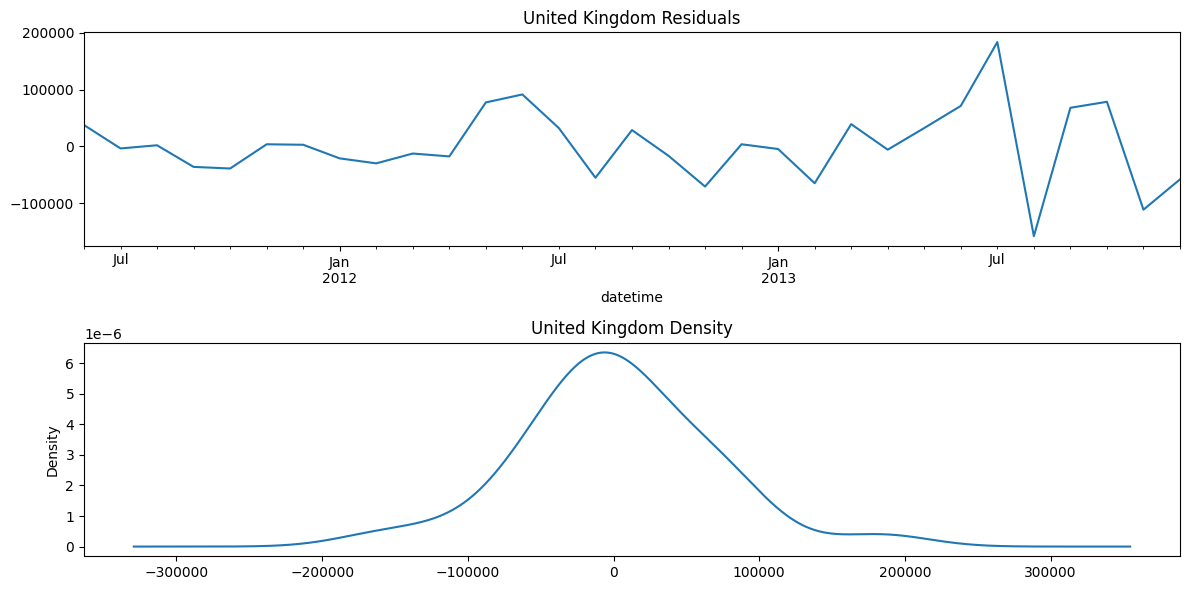

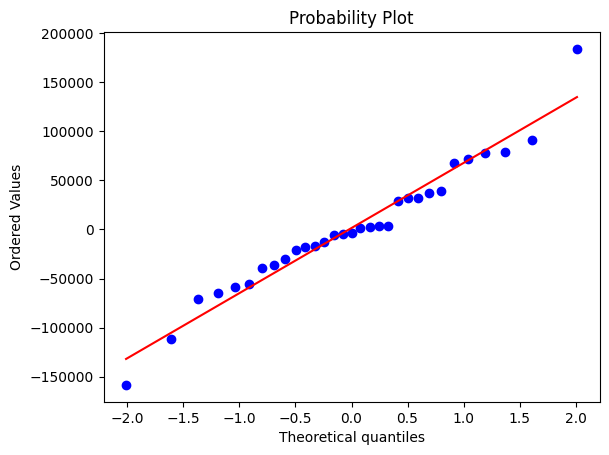

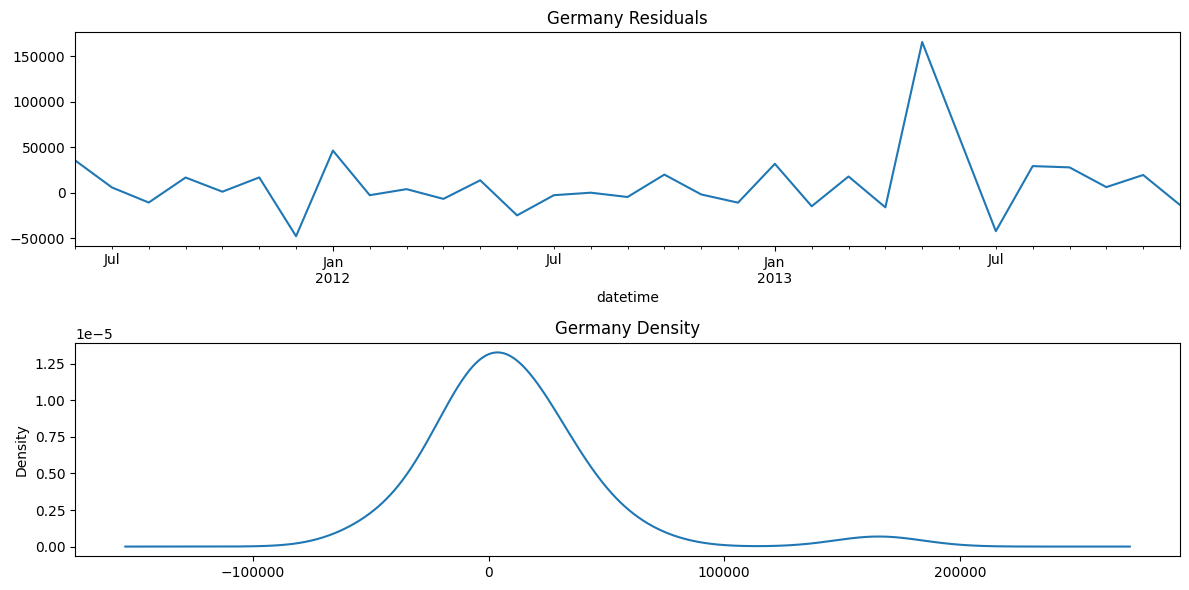

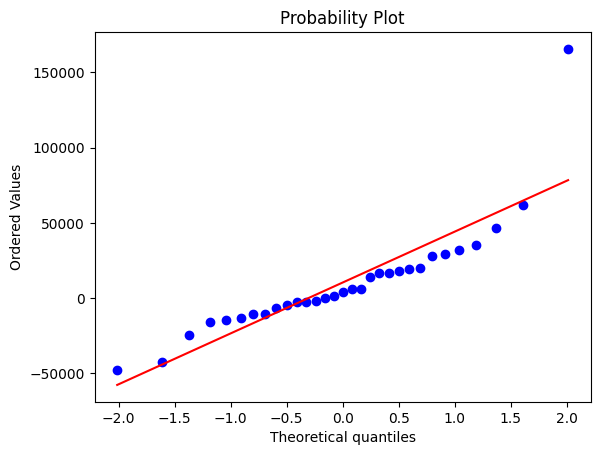

In [32]:
for (country, model) in model_fit_countries.items():
    # Plot residuals
    residuals = model.resid

    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    residuals.plot(title=country + " Residuals", ax=plt.gca())

    plt.subplot(212)
    residuals.plot(kind='kde', title=country + ' Density', ax=plt.gca())

    plt.tight_layout()
    plt.show()

    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()


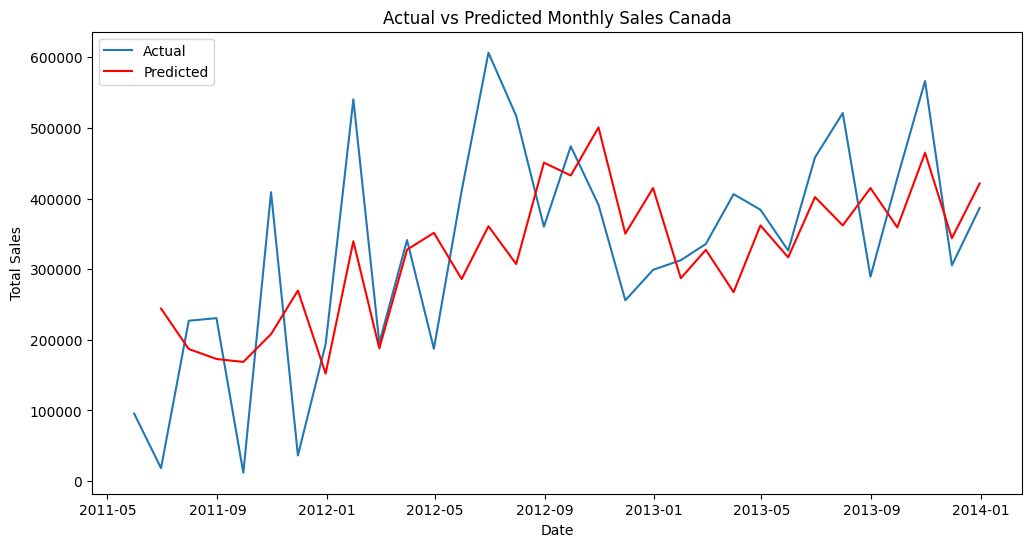

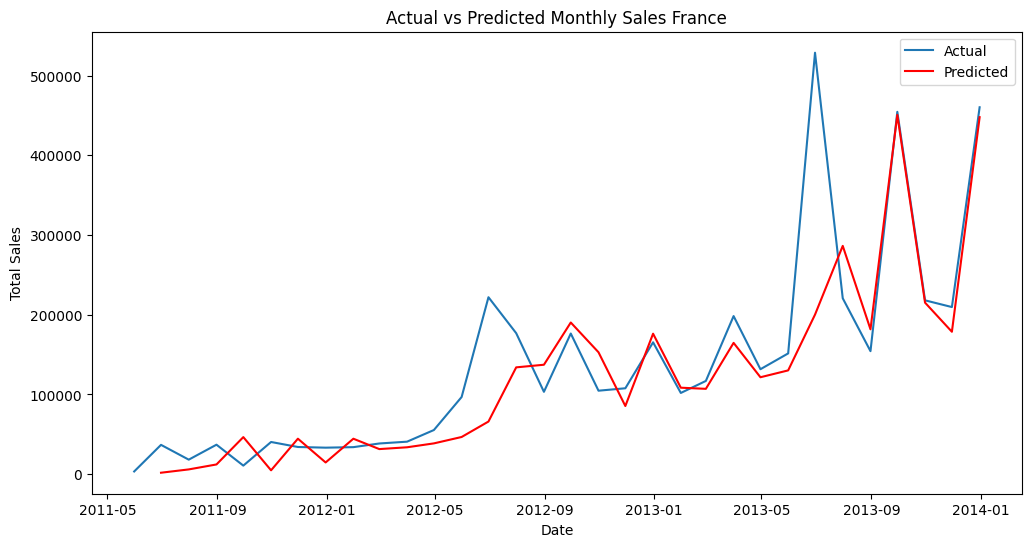

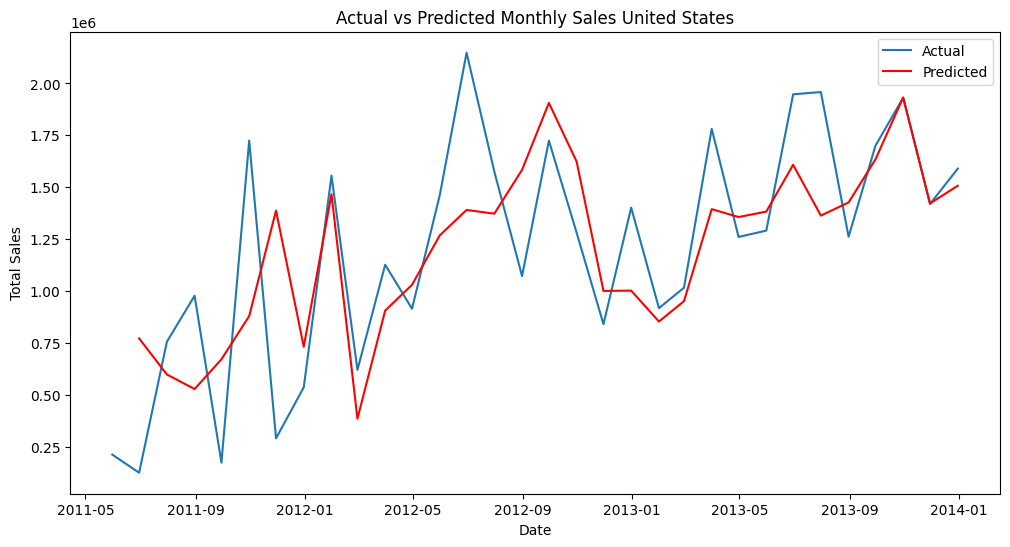

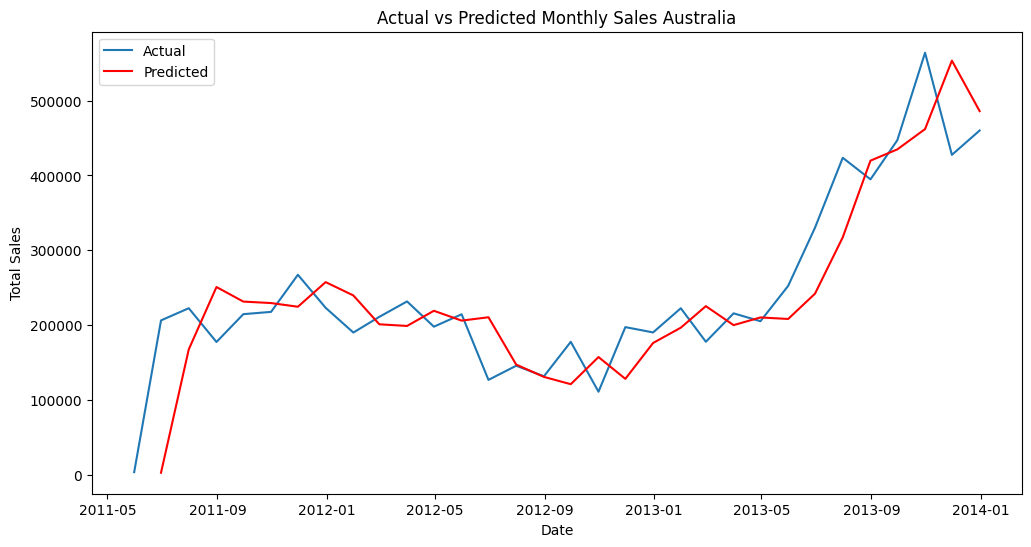

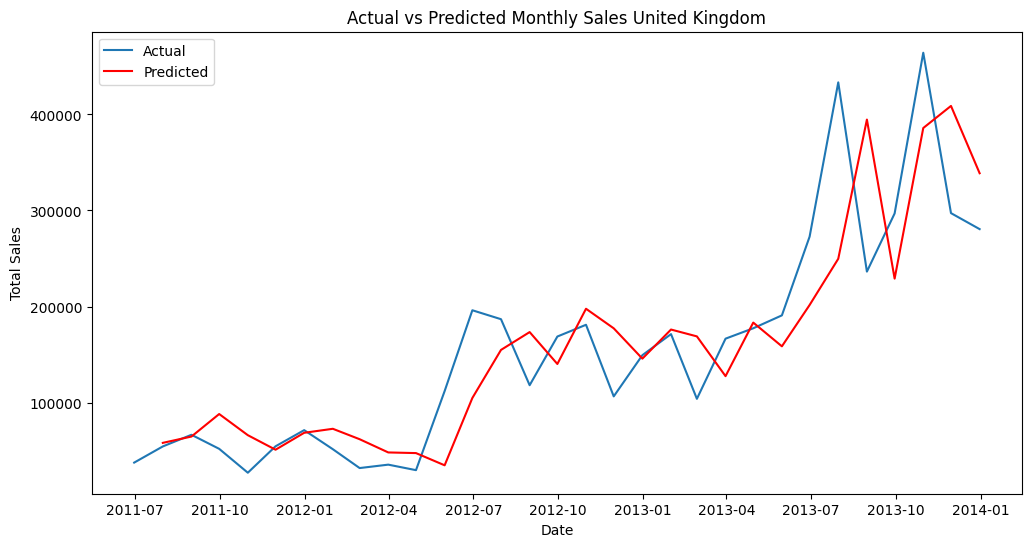

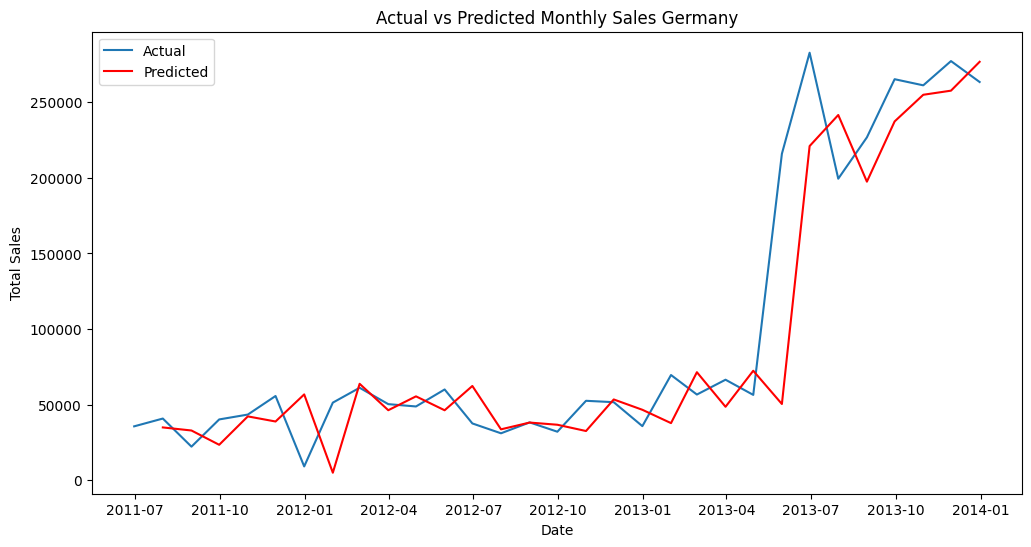

In [33]:
for (country, model) in model_fit_countries.items():
    # In-sample prediction
    predictions = model.predict(start=train_data[country].index[1], end=train_data[country].index[-1], typ='levels')

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[country], label='Actual')
    plt.plot(predictions, color='red', label='Predicted')
    plt.title('Actual vs Predicted Monthly Sales ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


In [34]:
last_date = train_data[countries[0]].index[-1]
last_date

Timestamp('2013-12-31 00:00:00')

C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\508738288.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


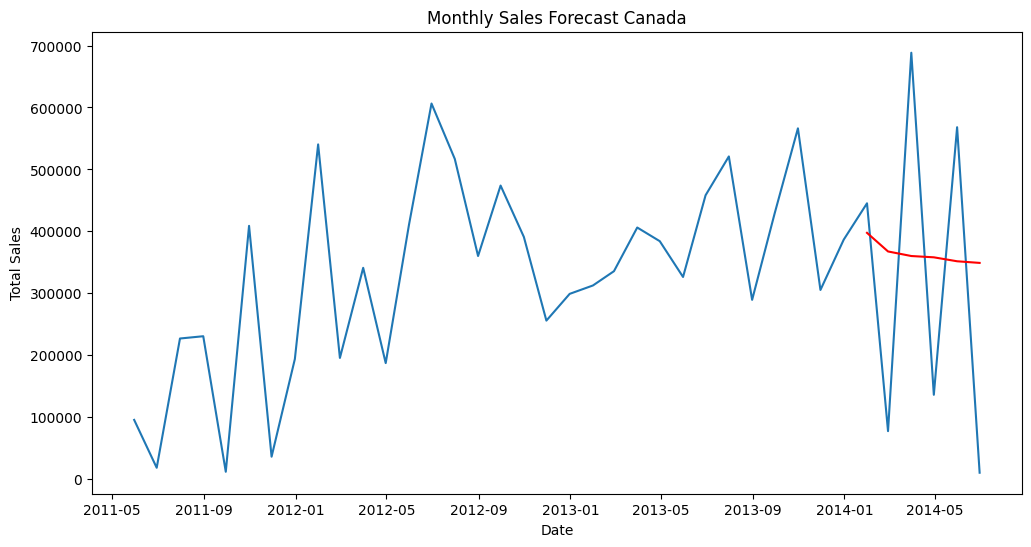

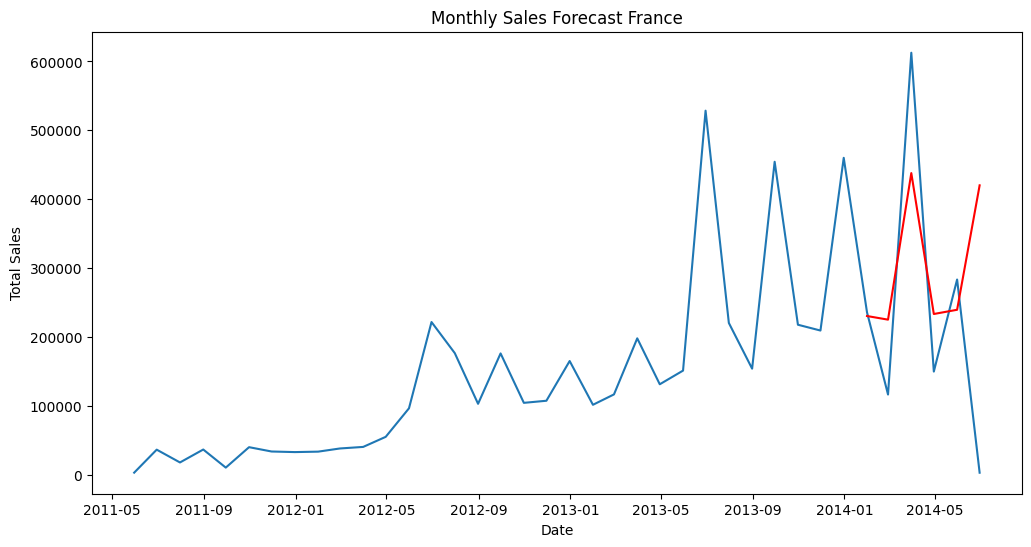

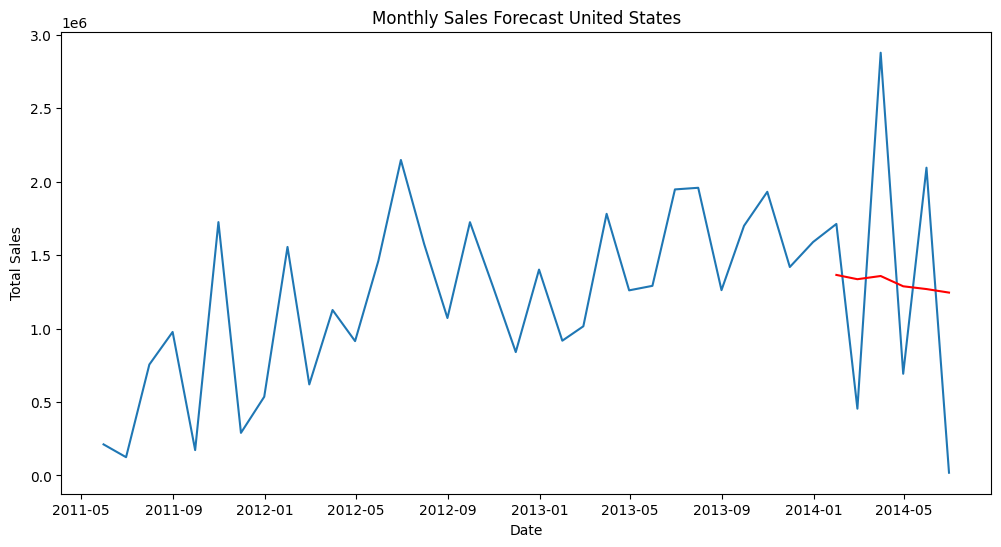

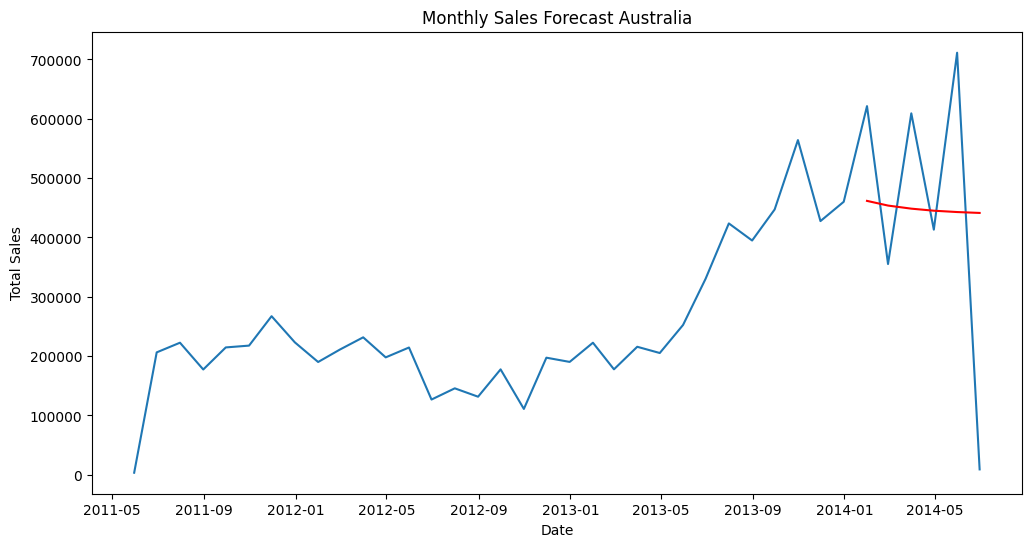

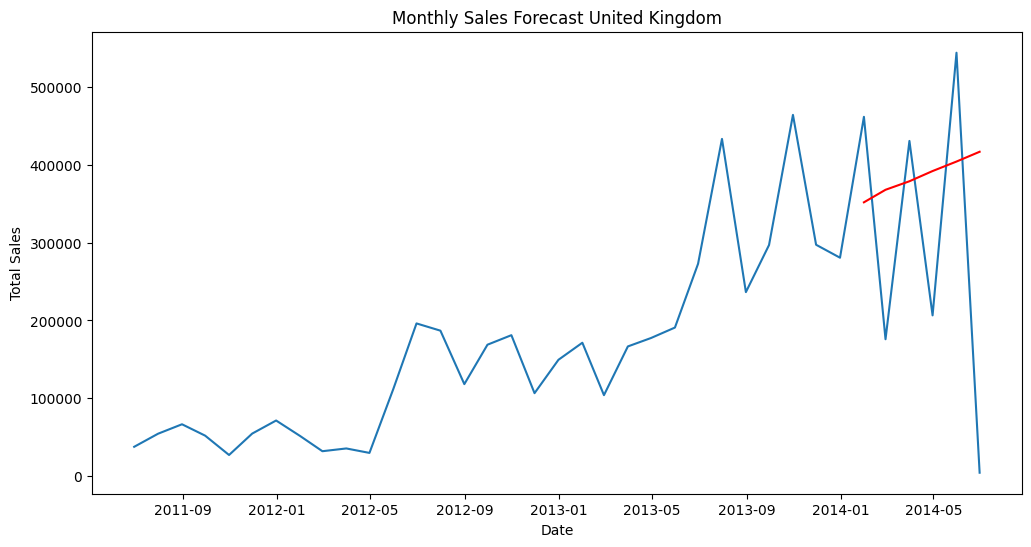

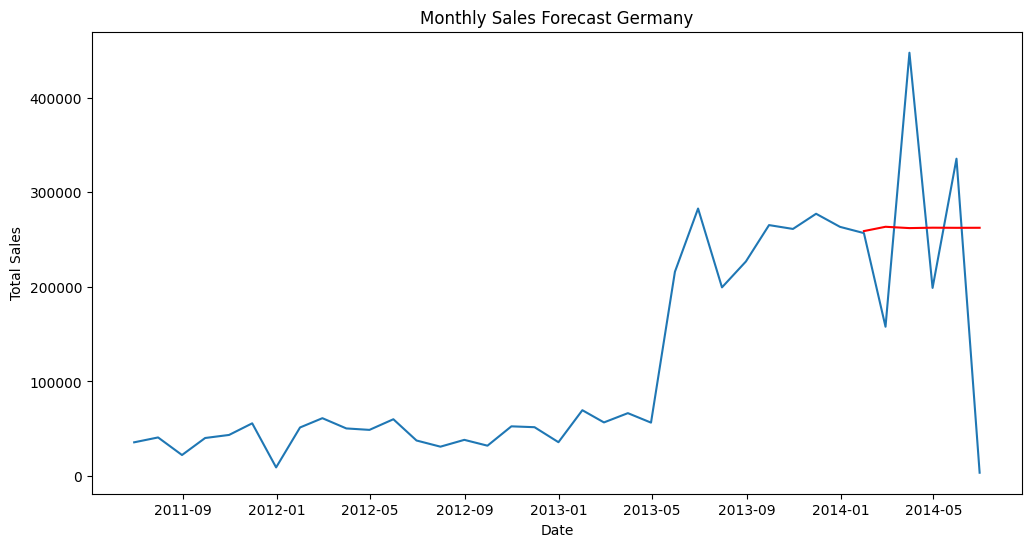

In [35]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')


In [36]:
# for (country, model) in model_fit_countries.items():
#     # Combine historical and forecast data
#     combined = pd.concat([monthly_sales_by_country[country], forecast_series], axis=0)

#     # Plot combined data
#     plt.figure(figsize=(12, 6))
#     plt.plot(combined, label='Combined Data')
#     plt.axvline(x=monthly_sales.index[-1], color='red', linestyle='--', label='Forecast Start')
#     plt.title('Historical and Forecasted Sales ' + country)
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.legend()
#     plt.show()


## SARIMA (no significant seasonality was detected in the data.)

In [37]:
from pmdarima import auto_arima

for country, series in train_data.items():
    print(f"Finding best ARIMA order for {country}...")
    model = auto_arima(series, seasonal=True, trace=True, stepwise=True)
    print(f"Best ARIMA order for {country}: {model.order}")

Finding best ARIMA order for Canada...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.701, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=843.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=835.881, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=831.911, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=841.922, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=829.257, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=830.640, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=831.905, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=830.777, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=831.204, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=832.809, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=828.903, Time=0.13 sec

Best model:  AR

## Machine Learning

In [38]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country(sales_data_country)

In [39]:
combined_data.keys()

dict_keys(['Canada', 'France', 'United States', 'Australia', 'United Kingdom', 'Germany'])

In [40]:
def add_lag(data, lags=3):
    lagged_data = {}  # To store the lagged DataFrames

    for country, series in data.items():
        print(f"Processing country: {country}")
        
        # Convert Series to DataFrame
        df = series.to_frame(name='sales')  # 'sales' becomes the column name
        
        # Add lag features
        for lag in range(1, lags + 1):
            df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
        
        # Drop NaN rows caused by lagging
        df = df.dropna()

        # Save the processed DataFrame
        lagged_data[country] = df
        
        # Display first rows for validation
        print(type(lagged_data[country]))
        
    
    return lagged_data

In [41]:
lagged_combined_data = add_lag(combined_data, 3)

Processing country: Canada
<class 'pandas.core.frame.DataFrame'>
Processing country: France
<class 'pandas.core.frame.DataFrame'>
Processing country: United States
<class 'pandas.core.frame.DataFrame'>
Processing country: Australia
<class 'pandas.core.frame.DataFrame'>
Processing country: United Kingdom
<class 'pandas.core.frame.DataFrame'>
Processing country: Germany
<class 'pandas.core.frame.DataFrame'>


In [42]:
def split_data(lagged_combined_data):
    lagged_train_data = {}
    lagged_test_data = {}
    
    for country, data in lagged_combined_data.items():
        lagged_train_data[country], lagged_test_data[country] = data[:-6], data[-6:]
        print(type(data))
        
    return lagged_train_data, lagged_test_data

In [43]:
lagged_train_data, lagged_test_data = split_data(lagged_combined_data)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [44]:
lagged_train_data

{'Canada':                   sales  sales_lag_1  sales_lag_2  sales_lag_3
 datetime                                                      
 2011-08-31  230723.1560  227046.2522   18387.1682   95655.0397
 2011-09-30   11929.7264  230723.1560  227046.2522   18387.1682
 2011-10-31  408931.9592   11929.7264  230723.1560  227046.2522
 2011-11-30   36278.5182  408931.9592   11929.7264  230723.1560
 2011-12-31  193883.2114   36278.5182  408931.9592   11929.7264
 2012-01-31  540411.1094  193883.2114   36278.5182  408931.9592
 2012-02-29  195665.0395  540411.1094  193883.2114   36278.5182
 2012-03-31  341175.2329  195665.0395  540411.1094  193883.2114
 2012-04-30  187343.0273  341175.2329  195665.0395  540411.1094
 2012-05-31  410703.2592  187343.0273  341175.2329  195665.0395
 2012-06-30  606395.3965  410703.2592  187343.0273  341175.2329
 2012-07-31  516949.3122  606395.3965  410703.2592  187343.0273
 2012-08-31  360226.8378  516949.3122  606395.3965  410703.2592
 2012-09-30  473956.7038  3602

In [45]:
print(lagged_test_data.values())

dict_values([                  sales  sales_lag_1  sales_lag_2  sales_lag_3
datetime                                                      
2014-01-31  445319.3277  386650.3960  305425.6094  566337.5012
2014-02-28   77497.2600  445319.3277  386650.3960  305425.6094
2014-03-31  688402.5747   77497.2600  445319.3277  386650.3960
2014-04-30  136178.3100  688402.5747   77497.2600  445319.3277
2014-05-31  568146.7268  136178.3100  688402.5747   77497.2600
2014-06-30   10381.5500  568146.7268  136178.3100  688402.5747,                   sales  sales_lag_1  sales_lag_2  sales_lag_3
datetime                                                      
2014-01-31  236074.4975  460185.7678  209593.9610  218031.3025
2014-02-28  116780.2700  236074.4975  460185.7678  209593.9610
2014-03-31  612672.7890  116780.2700  236074.4975  460185.7678
2014-04-30  150099.8900  612672.7890  116780.2700  236074.4975
2014-05-31  283645.5095  150099.8900  612672.7890  116780.2700
2014-06-30    3313.0100  283645.5095  150

In [46]:
def train_stacking_model(data):
    trained_models = {}
    scalers_X = {}

    for country, df in data.items():
        print(f"Training Stacking model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features only
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)

        # Initialize base models
        lr = LinearRegression()
        xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

        # Initialize stacking regressor
        stacking_model = StackingRegressor(
            estimators=[
                ('lr', lr),      # Linear Regression
                ('xgb', xgb)     # XGBoost
            ],
            final_estimator=LinearRegression()  # Meta-model
        )

        # Leave-One-Out Cross-Validation (LOOCV)
        loo = LeaveOneOut()
        y_preds = []
        y_actuals = []

        for train_index, test_index in loo.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train and predict with stacking model
            stacking_model.fit(X_train, y_train)
            y_pred = stacking_model.predict(X_test)

            y_preds.append(y_pred[0])
            y_actuals.append(y_test)

        # Compute LOOCV RMSE
        rmse = np.sqrt(mean_squared_error(y_actuals, y_preds))
        print(f"{country} - LOOCV RMSE: {rmse:.2f}")

        # Train on full data
        stacking_model.fit(X_scaled, y)

        # Save model and scaler
        trained_models[country] = stacking_model
        scalers_X[country] = scaler_X

    return trained_models, scalers_X

In [47]:
train_models, scalers_X = train_stacking_model(lagged_train_data)

Training Stacking model for Canada...
Canada - LOOCV RMSE: 167681.58
Training Stacking model for France...
France - LOOCV RMSE: 79787.75
Training Stacking model for United States...
United States - LOOCV RMSE: 481111.84
Training Stacking model for Australia...
Australia - LOOCV RMSE: 66426.66
Training Stacking model for United Kingdom...
United Kingdom - LOOCV RMSE: 76252.23
Training Stacking model for Germany...
Germany - LOOCV RMSE: 57704.88


In [48]:
train_models

{'Canada': StackingRegressor(estimators=[('lr', LinearRegression()),
                               ('xgb',
                                XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             lea

In [49]:
def test_simple_model(trained_models, scalers_X, test_data):
    countries_predict = {}
    
    for country, df in test_data.items():
        print(f"Testing model for {country}...")

        # Features and target
        X = df[['sales_lag_1', 'sales_lag_2', 'sales_lag_3']]
        y = df['sales']

        # Scale features using the saved scaler
        X_scaled = scalers_X[country].transform(X)

        # Predict
        y_pred = trained_models[country].predict(X_scaled)
        y_pred = pd.Series(y_pred, index=df.index)

        # Calculate MSE and RMSE
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        # Print evaluation metrics
        print(f"{country} - Mean Squared Error (MSE): {mse:.2f}")
        print(f"{country} - Root Mean Squared Error (RMSE): {rmse:.2f}\n")
        
        countries_predict[country] = y_pred
        
    return countries_predict

In [50]:
countries_predict = test_simple_model(train_models, scalers_X, lagged_test_data)

Testing model for Canada...
Canada - Mean Squared Error (MSE): 58465713342.78
Canada - Root Mean Squared Error (RMSE): 241796.84

Testing model for France...
France - Mean Squared Error (MSE): 72048716668.00
France - Root Mean Squared Error (RMSE): 268418.92

Testing model for United States...
United States - Mean Squared Error (MSE): 1029882818758.76
United States - Root Mean Squared Error (RMSE): 1014831.42

Testing model for Australia...
Australia - Mean Squared Error (MSE): 81592896394.74
Australia - Root Mean Squared Error (RMSE): 285644.70

Testing model for United Kingdom...
United Kingdom - Mean Squared Error (MSE): 58244597996.33
United Kingdom - Root Mean Squared Error (RMSE): 241339.18

Testing model for Germany...
Germany - Mean Squared Error (MSE): 42001929219.07
Germany - Root Mean Squared Error (RMSE): 204943.72



In [51]:
countries_predict

{'Canada': datetime
 2014-01-31    398834.938351
 2014-02-28    293822.272890
 2014-03-31    367289.046569
 2014-04-30    305329.080531
 2014-05-31    364008.837962
 2014-06-30    368765.159589
 Freq: ME, dtype: float64,
 'France': datetime
 2014-01-31    267862.237247
 2014-02-28    217149.473503
 2014-03-31    373027.494840
 2014-04-30    295907.822132
 2014-05-31    136920.385577
 2014-06-30    569872.610150
 Freq: ME, dtype: float64,
 'United States': datetime
 2014-01-31    1.624342e+06
 2014-02-28    1.426029e+06
 2014-03-31    1.474019e+06
 2014-04-30    1.183174e+06
 2014-05-31    1.172747e+06
 2014-06-30    1.489297e+06
 Freq: ME, dtype: float64,
 'Australia': datetime
 2014-01-31    441600.734983
 2014-02-28    519613.273553
 2014-03-31    423467.735654
 2014-04-30    501246.420882
 2014-05-31    440612.327038
 2014-06-30    569983.600139
 Freq: ME, dtype: float64,
 'United Kingdom': datetime
 2014-01-31    313323.520729
 2014-02-28    239665.097102
 2014-03-31    143838.7330

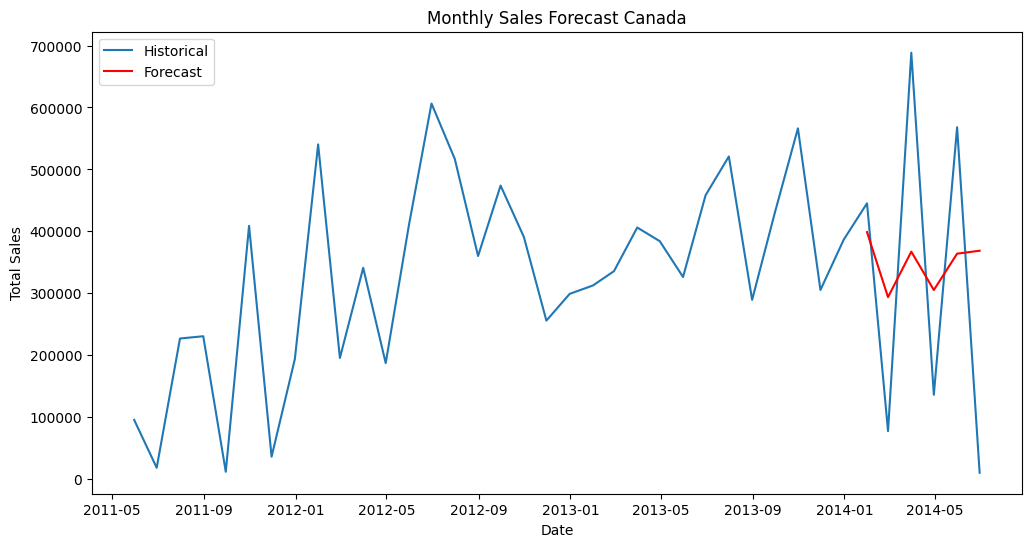

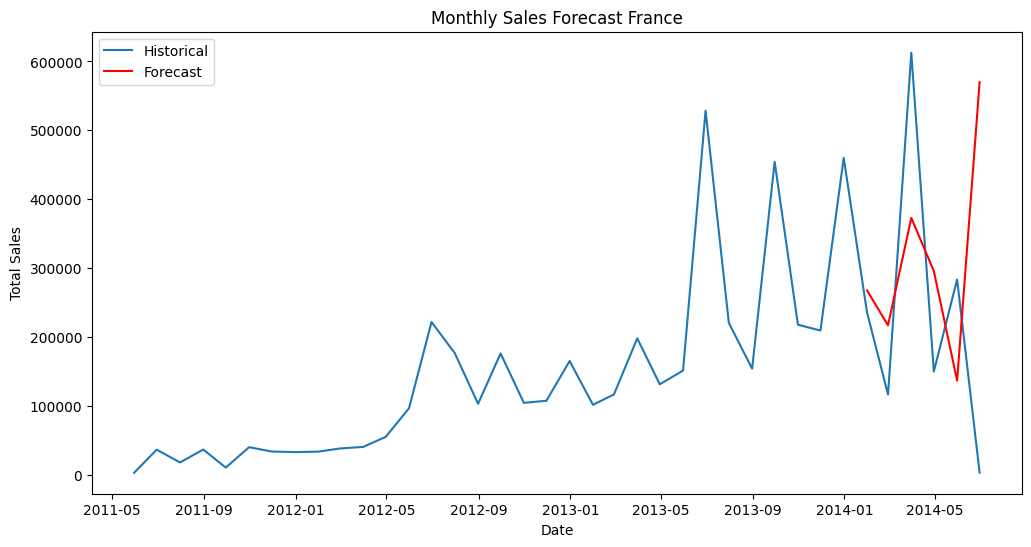

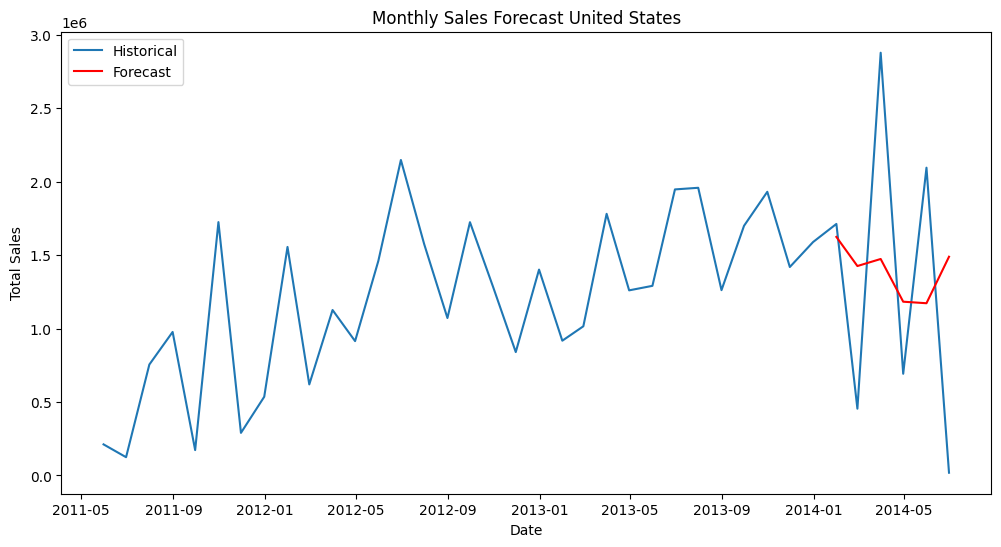

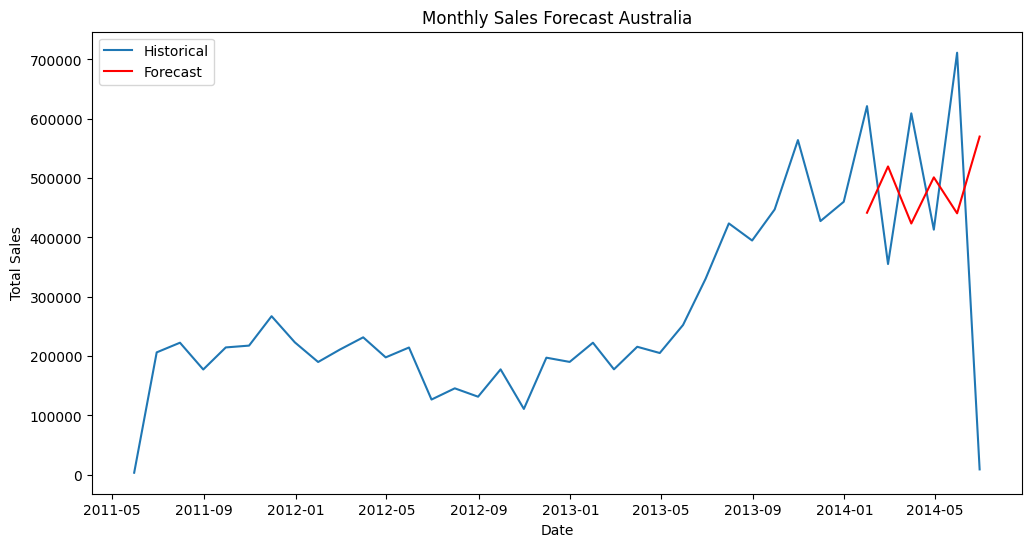

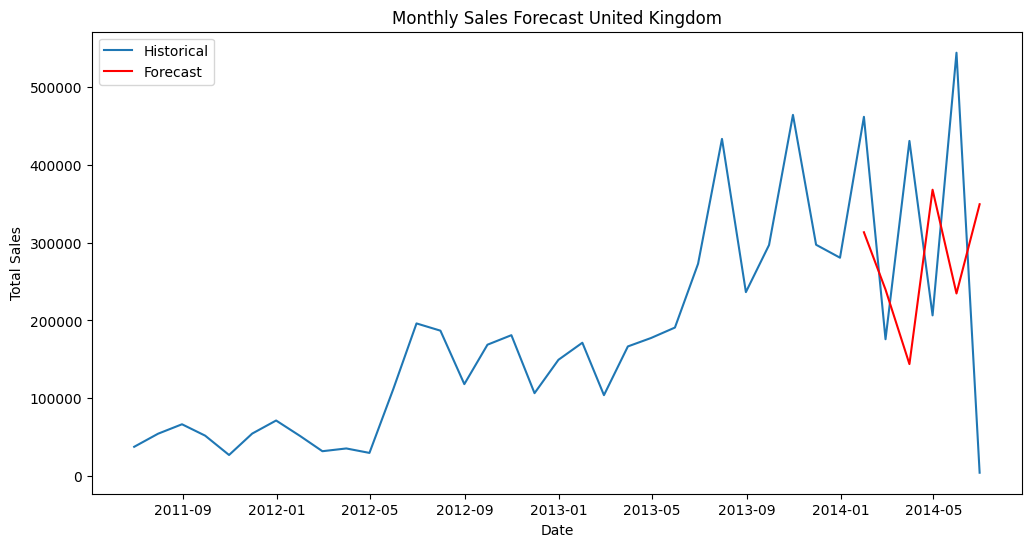

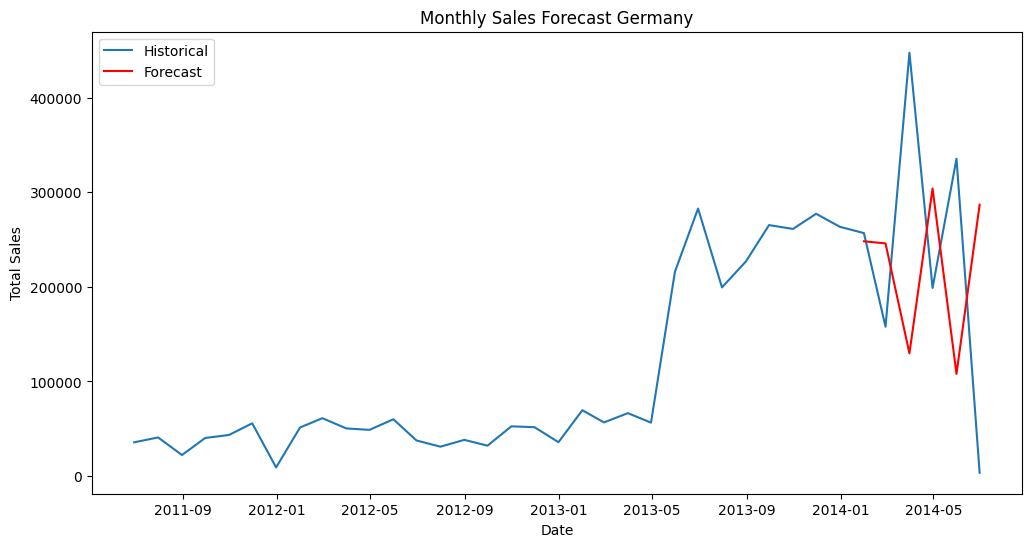

In [52]:
for (country, model) in model_fit_countries.items():

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(countries_predict[country], label='Forecast', color='red')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()

In [53]:
def forecast_next_months(trained_models, scalers_X, data, months=6):
    future_forecasts = {}

    for country, model in trained_models.items():
        print(f"Forecasting for {country}...")

        # Get the last row of the dataset for lagged features
        last_row = data[country].iloc[-1]
        lag_1, lag_2, lag_3 = last_row['sales_lag_1'], last_row['sales_lag_2'], last_row['sales_lag_3']

        # Start forecasting from the last date in the dataset
        last_date = data[country].index[-1]

        # Generate future dates
        future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]

        # List to store forecasts
        forecasts = []

        for date in future_dates:
            # Create features for the current prediction
            X_new = pd.DataFrame([[lag_1, lag_2, lag_3]], columns=['sales_lag_1', 'sales_lag_2', 'sales_lag_3'])

            # Scale features
            scaler_X = scalers_X[country]
            X_new_scaled = scaler_X.transform(X_new)

            # Predict the next month's sales
            next_sales = model.predict(X_new_scaled)[0]

            # Append prediction to the forecasts
            forecasts.append(next_sales)

            # Update lagged features
            lag_3 = lag_2
            lag_2 = lag_1
            lag_1 = next_sales

        # Convert forecasts to pandas Series with dates as the index
        future_forecasts[country] = pd.Series(data=forecasts, index=future_dates, name='forecast')

    return future_forecasts


In [54]:
future_forecasts = forecast_next_months(train_models, scalers_X, lagged_test_data, 6)
future_forecasts

Forecasting for Canada...
Forecasting for France...
Forecasting for United States...
Forecasting for Australia...
Forecasting for United Kingdom...
Forecasting for Germany...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[1:]
C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\681475447.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=months + 1, freq='M')[

{'Canada': 2014-07-31    368765.159589
 2014-08-31    352697.042932
 2014-09-30    386985.102125
 2014-10-31    358034.985611
 2014-11-30    351634.855342
 2014-12-31    355794.199408
 Freq: ME, Name: forecast, dtype: float64,
 'France': 2014-07-31    569872.610150
 2014-08-31    224035.878231
 2014-09-30    276851.651310
 2014-10-31    544535.491154
 2014-11-30    285075.150149
 2014-12-31    281576.937778
 Freq: ME, Name: forecast, dtype: float64,
 'United States': 2014-07-31    1.489297e+06
 2014-08-31    1.193814e+06
 2014-09-30    1.666622e+06
 2014-10-31    1.505672e+06
 2014-11-30    1.313793e+06
 2014-12-31    1.527385e+06
 Freq: ME, Name: forecast, dtype: float64,
 'Australia': 2014-07-31    569983.600139
 2014-08-31    546928.089559
 2014-09-30    529809.379562
 2014-10-31    505162.165283
 2014-11-30    487008.545715
 2014-12-31    470755.090496
 Freq: ME, Name: forecast, dtype: float64,
 'United Kingdom': 2014-07-31    349351.967574
 2014-08-31    237196.594081
 2014-09-30 

C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\1407805102.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


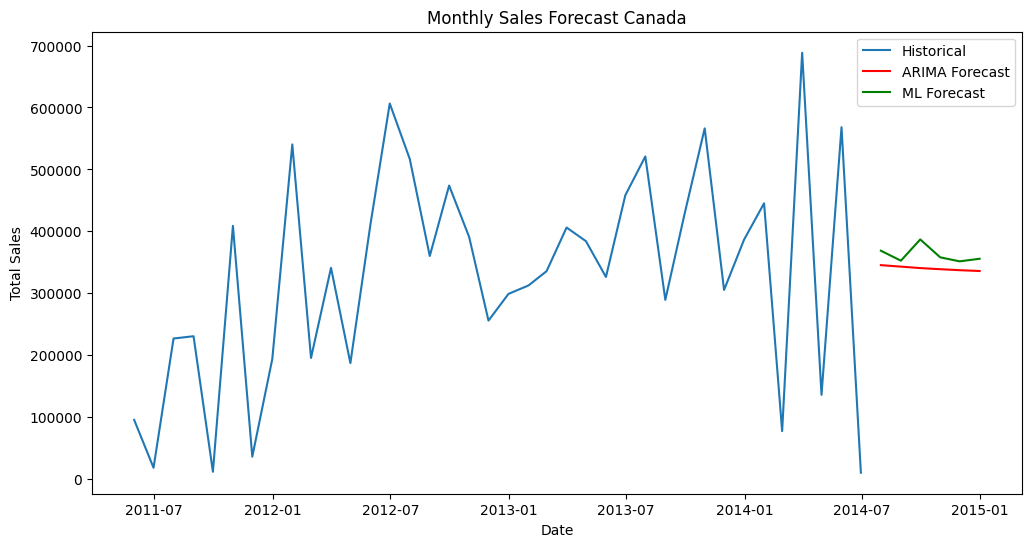

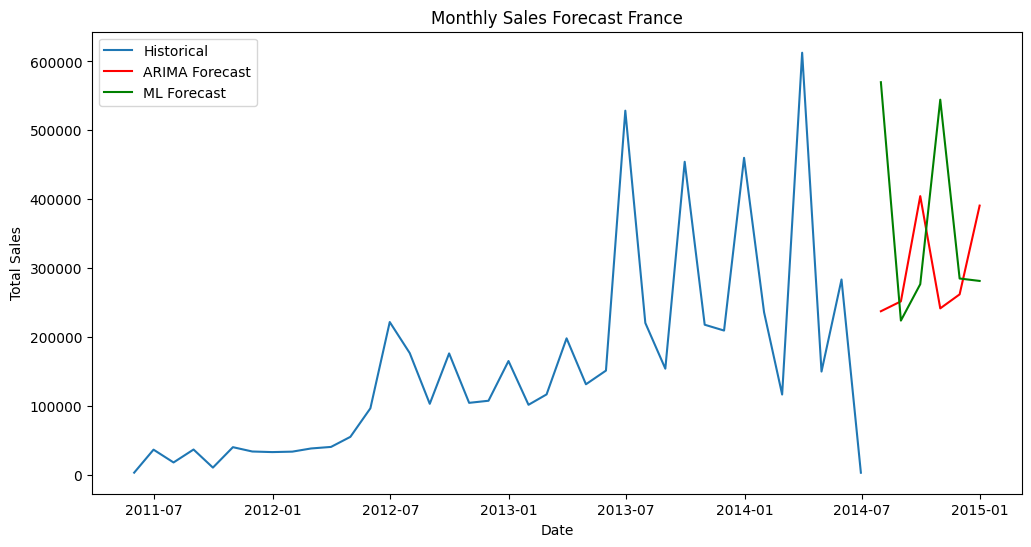

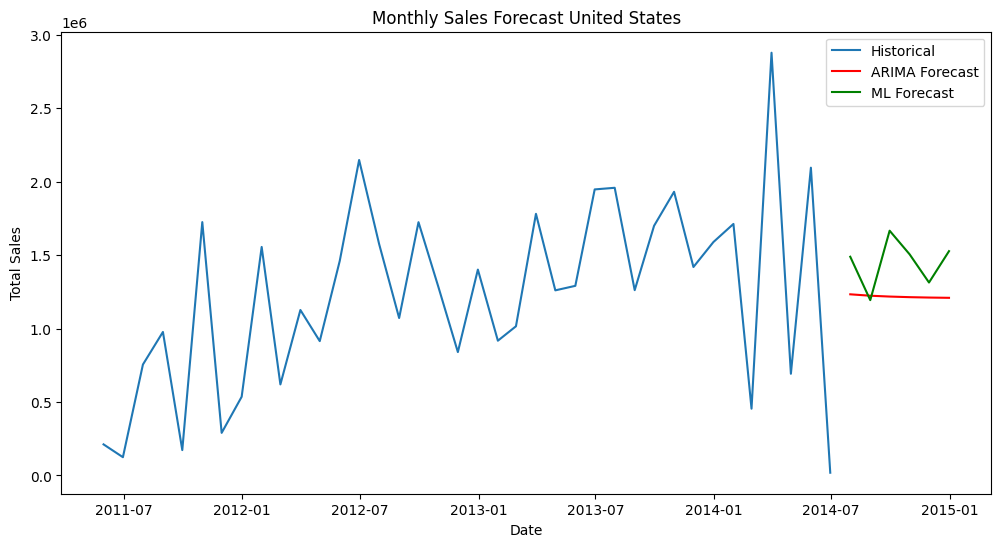

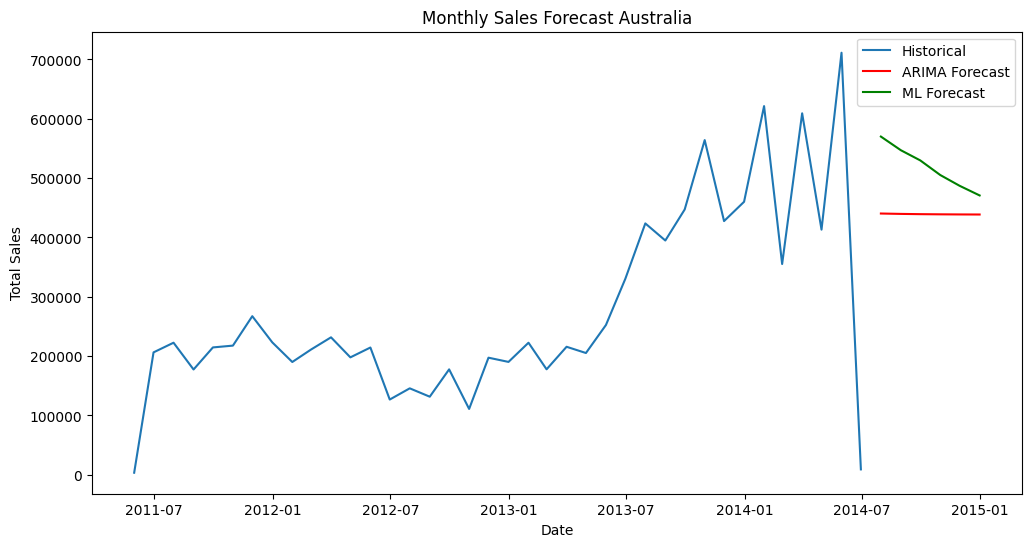

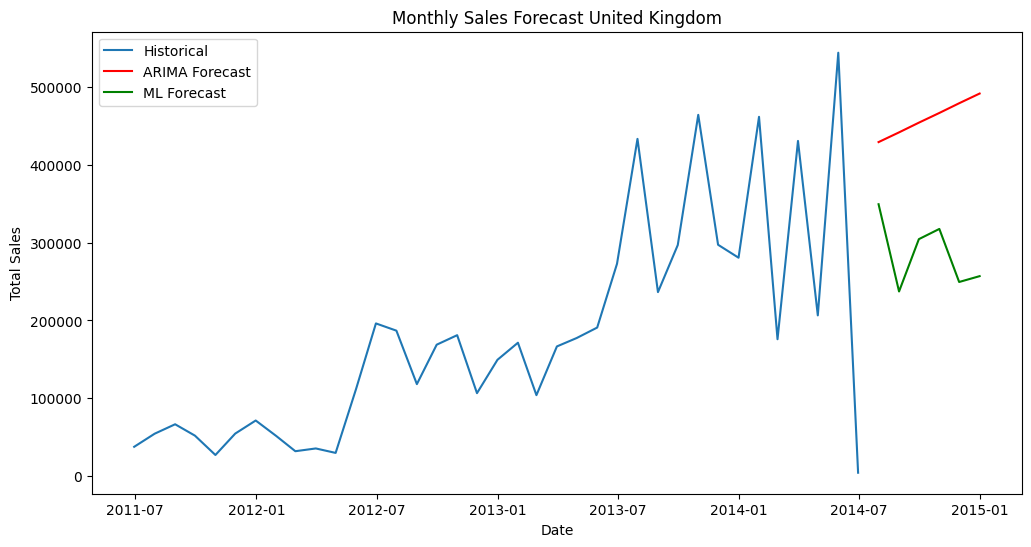

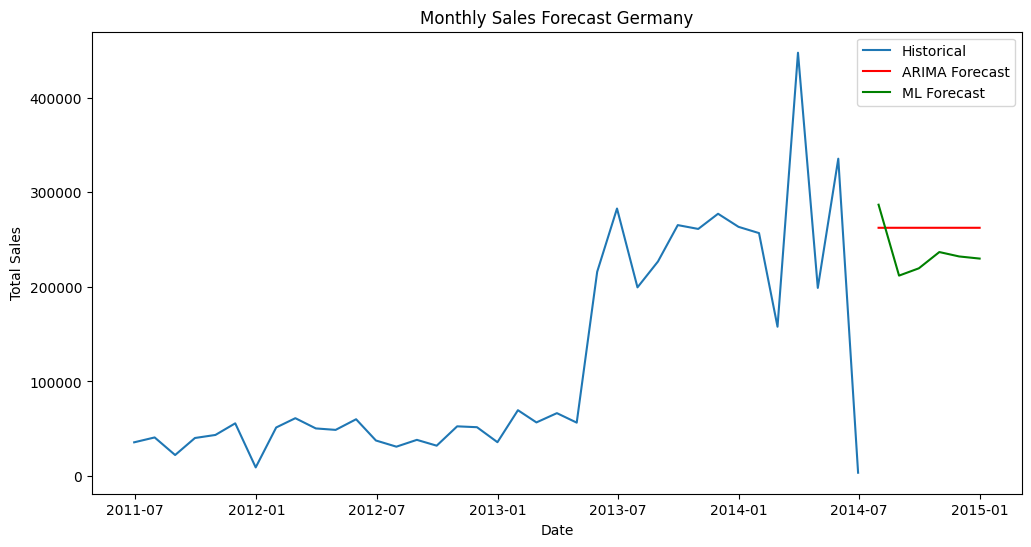

In [55]:
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.show()


## LSTM

In [56]:
def train_test_split_country_lstm(sales_data_country):
    combine_train_test = {
        country: data['LineTotal'].resample('ME').sum() for country, data in sales_data_country.items()
    }
    
    
    train_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[:-6] for country, data in sales_data_country.items()
    }
    
    test_monthly_sales_by_country = {
        country: data['LineTotal'].resample('ME').sum()[-9:] for country, data in sales_data_country.items()
    }
    
    return (combine_train_test, train_monthly_sales_by_country, test_monthly_sales_by_country)

In [57]:
# Resample 'LineTotal' for each country in the dictionary
combined_data, train_data, test_data = train_test_split_country_lstm(sales_data_country)

In [58]:
test_data

{'Canada': datetime
 2013-10-31    566337.5012
 2013-11-30    305425.6094
 2013-12-31    386650.3960
 2014-01-31    445319.3277
 2014-02-28     77497.2600
 2014-03-31    688402.5747
 2014-04-30    136178.3100
 2014-05-31    568146.7268
 2014-06-30     10381.5500
 Freq: ME, Name: LineTotal, dtype: float64,
 'France': datetime
 2013-10-31    218031.3025
 2013-11-30    209593.9610
 2013-12-31    460185.7678
 2014-01-31    236074.4975
 2014-02-28    116780.2700
 2014-03-31    612672.7890
 2014-04-30    150099.8900
 2014-05-31    283645.5095
 2014-06-30      3313.0100
 Freq: ME, Name: LineTotal, dtype: float64,
 'United States': datetime
 2013-10-31    1.931507e+06
 2013-11-30    1.419395e+06
 2013-12-31    1.589563e+06
 2014-01-31    1.712674e+06
 2014-02-28    4.546562e+05
 2014-03-31    2.878493e+06
 2014-04-30    6.924442e+05
 2014-05-31    2.095694e+06
 2014-06-30    1.867323e+04
 Freq: ME, Name: LineTotal, dtype: float64,
 'Australia': datetime
 2013-10-31    564042.2786
 2013-11-30  

In [59]:
def train_lstm_with_generator(data, look_back=3, batch_size=4, epochs=50):
    trained_models = {}
    scalers = {}

    for country, df in data.items():
        print(f"Training LSTM model for {country}...")

        # Scale sales data
        df = pd.Series.to_frame(df)
        scaler = MinMaxScaler(feature_range=(0, 1))
        sales_scaled = scaler.fit_transform(df)

        # Use TimeseriesGenerator to create input-output pairs
        generator = TimeseriesGenerator(sales_scaled, sales_scaled, length=look_back, batch_size=batch_size)

        # Build LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))  # Input shape: (look_back, n_features=1)
        model.add(Dense(1))  # Predict the next step
        model.compile(optimizer='adam', loss='mse')

        # Train the model using generator
        model.fit(generator, epochs=epochs, verbose=1)

        # Save the model and scaler
        trained_models[country] = model
        scalers[country] = scaler

        print(f"{country} - Training completed.")

    return trained_models, scalers

In [60]:
lstm_models, lstm_scalers = train_lstm_with_generator(train_data, look_back=3)

Training LSTM model for Canada...
Epoch 1/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3930
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2556 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2429 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1614 
Epoch 5/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2897

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1829 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1259 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0921 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0540 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0390 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0566 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0451 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0659 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0630 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0662 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0550 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0414 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0600 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0596 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1118
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1906 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2002 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1041 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0575     
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0013

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0737 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0879 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0806 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1012 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0649 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0385 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0783 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0414 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0401 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0385 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0356 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0450 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0304 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0400 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0561 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3400
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3237 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3332 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2670 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1820 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1245

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1695 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1228 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0740 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0717 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0590 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0379 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0365 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0380     
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0380 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0352 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0490 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0406 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0519 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1551
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2494 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2417 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0860 
Epoch 6/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1207

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0731 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0829 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0662 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0301 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0181 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0158 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0189 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0168 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0162 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0179 
Epoch 17/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0207 
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176 
Epoch 19/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0164 
Epoch 20/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0195 
Epoch 21/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1592
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0948 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1101     
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0959 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1096 
Epoch 6/50
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0017

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1240 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0874 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1403 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0876 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0746 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0756 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0584 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 
Epoch 21/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2997
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0794 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0743 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 
Epoch 5/50


c:\Users\Hi There\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1028 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1091     
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0855     
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1539 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0524 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0798 
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0996 
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1266 
Epoch 15/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0585 
Epoch 16/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0828 
Epoch 17/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0879 
Epoch 18/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0577 
Epoch 19/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0834 
Epoch 20/50
7/7 ━━━━━━━━━━━━━━━━━

In [61]:
def test_lstm_model(trained_models, scalers, test_data, look_back=3):
    predictions = {}

    for country, df in test_data.items():
        print(f"Testing LSTM model for {country}...")
        
        # Save the original index to align predictions later
        original_index = df.index

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Ensure look_back does not exceed the available data length
        if len(scaled_data) <= look_back:
            print(f"Not enough data for {country}: reducing look_back to {len(scaled_data) - 1}")
            look_back = len(scaled_data) - 1

        # Prepare input sequences using TimeseriesGenerator
        generator = TimeseriesGenerator(scaled_data, scaled_data, length=look_back, batch_size=1)

        # Get the trained model
        model = trained_models[country]

        # Make predictions
        y_pred_scaled = []
        for i in range(len(generator)):
            X, _ = generator[i]  # Get input sequence
            y_pred = model.predict(X, verbose=0)  # Predict next step
            y_pred_scaled.append(y_pred[0][0])  # Append prediction

        # Inverse transform predictions back to original scale
        y_pred = scaler.inverse_transform(np.array(y_pred_scaled).reshape(-1, 1)).ravel()

        # Align predictions with the correct index
        prediction_index = original_index[-len(y_pred):]
        predictions[country] = pd.Series(y_pred, index=prediction_index)

        print(f"{country} - Testing completed.")

    return predictions


In [62]:
lstm_res = test_lstm_model(lstm_models, lstm_scalers, test_data)

Testing LSTM model for Canada...
Canada - Testing completed.
Testing LSTM model for France...
France - Testing completed.
Testing LSTM model for United States...
United States - Testing completed.
Testing LSTM model for Australia...
Australia - Testing completed.
Testing LSTM model for United Kingdom...
United Kingdom - Testing completed.
Testing LSTM model for Germany...
Germany - Testing completed.


In [63]:
lstm_res

{'Canada': datetime
 2014-01-31    403108.75000
 2014-02-28    362066.37500
 2014-03-31    352845.68750
 2014-04-30    368576.46875
 2014-05-31    336198.65625
 2014-06-30    425013.87500
 Freq: ME, dtype: float32,
 'France': datetime
 2014-01-31    295823.75000
 2014-02-28    341147.28125
 2014-03-31    412712.62500
 2014-04-30    297586.59375
 2014-05-31    316159.90625
 2014-06-30    515684.65625
 Freq: ME, dtype: float32,
 'United States': datetime
 2014-01-31    1633936.375
 2014-02-28    1505092.625
 2014-03-31    1458809.625
 2014-04-30    1483225.000
 2014-05-31    1384606.125
 2014-06-30    1877878.875
 Freq: ME, dtype: float32,
 'Australia': datetime
 2014-01-31    486991.21875
 2014-02-28    488696.43750
 2014-03-31    481788.21875
 2014-04-30    529376.62500
 2014-05-31    452349.06250
 2014-06-30    575958.37500
 Freq: ME, dtype: float32,
 'United Kingdom': datetime
 2014-01-31    370057.09375
 2014-02-28    343452.31250
 2014-03-31    315608.15625
 2014-04-30    364391.43

In [64]:
def forecast_lstm_model(trained_models, scalers, test_data, look_back=3, forecast_steps=6):
    forecasts = {}

    for country, df in test_data.items():
        print(f"Forecasting next {forecast_steps} months for {country}...")

        # Ensure df is a DataFrame and retain the original index
        if isinstance(df, pd.Series):
            df = pd.Series.to_frame(df)

        # Scale the sales data using the saved scaler
        scaler = scalers[country]
        scaled_data = scaler.transform(df)

        # Start with the last look_back window of scaled data
        last_window = scaled_data[-look_back:].reshape(1, look_back, 1)

        # Initialize list to store predictions
        forecast_scaled = []

        # Get the trained model
        model = trained_models[country]

        # Iteratively predict the next steps
        for step in range(forecast_steps):
            # Predict next value
            next_pred = model.predict(last_window, verbose=0)[0][0]
            forecast_scaled.append(next_pred)

            # Update the input window: remove oldest value, append predicted value
            last_window = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)

        # Inverse transform predictions back to original scale
        forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).ravel()

        # Create a date range for the forecast period
        start_date = df.index[-1]  # Last date in the test data
        forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

        # Store forecast as a Pandas Series
        forecasts[country] = pd.Series(forecast, index=forecast_index)

        print(f"{country} - Forecasting completed.")

    return forecasts


In [65]:
forecast_lstms = forecast_lstm_model(lstm_models, lstm_scalers, test_data)

Forecasting next 6 months for Canada...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Canada - Forecasting completed.
Forecasting next 6 months for France...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


France - Forecasting completed.
Forecasting next 6 months for United States...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United States - Forecasting completed.
Forecasting next 6 months for Australia...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Australia - Forecasting completed.
Forecasting next 6 months for United Kingdom...


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


United Kingdom - Forecasting completed.
Forecasting next 6 months for Germany...
Germany - Forecasting completed.


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\368940772.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=start_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


In [66]:
forecast_lstms

{'Canada': 2014-07-31    313531.37500
 2014-08-31    343073.56250
 2014-09-30    272544.34375
 2014-10-31    336001.62500
 2014-11-30    337419.53125
 2014-12-31    332423.90625
 Freq: ME, dtype: float32,
 'France': 2014-07-31    190651.890625
 2014-08-31    213047.437500
 2014-09-30    121854.585938
 2014-10-31    215134.453125
 2014-11-30    215215.171875
 2014-12-31    191653.609375
 Freq: ME, dtype: float32,
 'United States': 2014-07-31    1.211935e+06
 2014-08-31    1.339533e+06
 2014-09-30    9.522016e+05
 2014-10-31    1.308698e+06
 2014-11-30    1.307202e+06
 2014-12-31    1.253521e+06
 Freq: ME, dtype: float32,
 'Australia': 2014-07-31    396159.56250
 2014-08-31    391882.78125
 2014-09-30    270448.46875
 2014-10-31    359098.96875
 2014-11-30    343887.62500
 2014-12-31    325671.46875
 Freq: ME, dtype: float32,
 'United Kingdom': 2014-07-31    254334.671875
 2014-08-31    278530.281250
 2014-09-30    188425.375000
 2014-10-31    263972.125000
 2014-11-30    269801.843750
 

In [67]:
# Initialize a dictionary to store MSE for each forecast method
rmse_results = {}

# Directory to save figures
output_dir = "results\\countries\\test"
os.makedirs(output_dir, exist_ok=True)

for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 6
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]
    
    # Actual data (test data for evaluation)
    actual = combined_data[country][-len(forecast_series):]  # Align test period with forecast

    # Forecasts
    arima_forecast = forecast_series
    ml_forecast = countries_predict[country]
    lstm_forecast = lstm_res[country]

    # Calculate MSE for each method
    rmse_arima = root_mean_squared_error(actual, arima_forecast)
    rmse_ml = root_mean_squared_error(actual, ml_forecast)
    rmse_lstm = root_mean_squared_error(actual, lstm_forecast)

    # Store MSE in dictionary
    rmse_results[country] = {
        'ARIMA': rmse_arima,
        'ML': rmse_ml,
        'LSTM': rmse_lstm
    }
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(countries_predict[country], label='ML Forecast', color='green')
    plt.plot(lstm_res[country], label='LSTM Forecast', color='black')

    # Add MSE as text box (top-left)
    mse_text = (f"ARIMA MSE: {rmse_arima:.2e}\n"
                f"ML MSE: {rmse_ml:.2e}\n"
                f"LSTM MSE: {rmse_lstm:.2e}")
    plt.text(0.02, 0.85, mse_text, transform=plt.gca().transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))

    # Add the legend at the bottom
    plt.legend(loc='upper left', bbox_to_anchor=(0.0, 0.8))  # Position legend below MSE box

    # Add labels and title
    plt.title('Monthly Sales Forecast ' + country)
    plt.xlabel('Date')
    plt.ylabel('Total Sales')

    # Save the plot
    figure_path = os.path.join(output_dir, f"{country}_forecast.png")
    plt.savefig(figure_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to save memory
    
    print(f"Saved plot for {country} at: {figure_path}")

# Display the MSE results
for country, errors in rmse_results.items():
    print(f"\n--- {country} ---")
    for method, rmse in errors.items():
        print(f"{method} RMSE: {rmse:.2e}")


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Canada at: results\countries\test\Canada_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for France at: results\countries\test\France_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for United States at: results\countries\test\United States_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Australia at: results\countries\test\Australia_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for United Kingdom at: results\countries\test\United Kingdom_forecast.png


C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\2546192876.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Germany at: results\countries\test\Germany_forecast.png

--- Canada ---
ARIMA RMSE: 2.60e+05
ML RMSE: 2.42e+05
LSTM RMSE: 2.81e+05

--- France ---
ARIMA RMSE: 1.94e+05
ML RMSE: 2.68e+05
LSTM RMSE: 2.51e+05

--- United States ---
ARIMA RMSE: 9.79e+05
ML RMSE: 1.01e+06
LSTM RMSE: 1.13e+06

--- Australia ---
ARIMA RMSE: 2.31e+05
ML RMSE: 2.86e+05
LSTM RMSE: 2.75e+05

--- United Kingdom ---
ARIMA RMSE: 2.14e+05
ML RMSE: 2.41e+05
LSTM RMSE: 2.21e+05

--- Germany ---
ARIMA RMSE: 1.43e+05
ML RMSE: 2.05e+05
LSTM RMSE: 1.89e+05


In [68]:
# Function to calculate confidence intervals
def calculate_conf_level(series, alpha):
    n = len(series)
    mean = series.mean()
    std = series.std(ddof=1)
    t_critical = t.ppf(1 - alpha / 2, df=n - 1)
    margin_of_error = t_critical * (std / np.sqrt(n))
    return mean - margin_of_error, mean + margin_of_error

In [69]:
calculate_conf_level(future_forecasts['Canada'], 0.05)

(348101.67991994653, 376535.43508225254)

In [70]:
# Directory to save plots
output_dir = "results\\countries\\forecast"
os.makedirs(output_dir, exist_ok=True)

# Dictionary to store forecasts and confidence intervals
lower_bounds = {}
upper_bounds = {}

# Loop through each country and plot forecasts
for (country, model) in model_fit_countries.items():
    # Forecasting
    forecast_steps = 12
    forecast = model.forecast(steps=forecast_steps)

    # Create future dates
    last_date = train_data[country].index[-1]
    forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

    # Create forecast series
    forecast_series = pd.Series(forecast, index=forecast_index)[-6:]

    # Calculate confidence intervals for each forecast method
    arima_conf = calculate_conf_level(forecast_series, 0.05)
    ml_conf = calculate_conf_level(future_forecasts[country], 0.05)
    lstm_conf = calculate_conf_level(forecast_lstms[country], 0.05)

    lower_bounds[country] = {
        'ARIMA': arima_conf[0],
        'ML': ml_conf[0],
        'LSTM': lstm_conf[0]
    }
    
    upper_bounds[country] = {
        'ARIMA': arima_conf[1],
        'ML': ml_conf[1],
        'LSTM': lstm_conf[1]
    }
    
    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data[country], label='Historical')
    plt.plot(forecast_series, label='ARIMA Forecast', color='red')
    plt.plot(future_forecasts[country], label='ML Forecast', color='green')
    plt.plot(forecast_lstms[country], label='LSTM Forecast', color='black')

    # Add confidence intervals as shaded regions
    plt.fill_between(forecast_series.index, lower_bounds[country]['ARIMA'], upper_bounds[country]['ARIMA'], 
                     color='red', alpha=0.2, label='ARIMA CI')
    plt.fill_between(future_forecasts[country].index, lower_bounds[country]['ML'], upper_bounds[country]['ML'], 
                     color='green', alpha=0.2, label='ML CI')
    plt.fill_between(forecast_lstms[country].index, lower_bounds[country]['LSTM'], upper_bounds[country]['LSTM'], 
                     color='black', alpha=0.2, label='LSTM CI')

    # Add titles and labels
    plt.title(f'Monthly Sales Forecast for {country}')
    plt.xlabel('Date')
    plt.ylabel('Total Sales')
    plt.legend()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, f"{country}_forecast.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to save memory
    
    print(f"Saved plot for {country} at: {plot_path}")

C:\Users\Hi There\AppData\Local\Temp\ipykernel_18092\488416027.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


Saved plot for Canada at: results\countries\forecast\Canada_forecast.png
Saved plot for France at: results\countries\forecast\France_forecast.png
Saved plot for United States at: results\countries\forecast\United States_forecast.png
Saved plot for Australia at: results\countries\forecast\Australia_forecast.png
Saved plot for United Kingdom at: results\countries\forecast\United Kingdom_forecast.png
Saved plot for Germany at: results\countries\forecast\Germany_forecast.png


In [71]:
lower_bounds['Canada']

{'ARIMA': 336517.8462900866,
 'ML': 348101.67991994653,
 'LSTM': 294723.0832026581}